# Table des matières

### [Introduction](#I)

### [Importation du jeu de données](#T1)
- [Importation des librairies](#T1C1)
- [Importation du jeu de données](#T1C2)
- [Fonctions d'affichages](#T1C3)

### [Exploration du jeu de données](#T2)
- [Jeu de données](#T2C1)
- [Fusion + data engineering : LightGBM with Simple Features](#T2C2)

### [Modélisations](#T3)
- [Pipeline](#T3C1)
- [DummyClassifier](#T3C2)
- [KNeighborsClassifier](#T3C3)
- [RandomForestClassifier](#T3C4)
- [LogisticRegression](#T3C5)
- [GradientBoostingClassifier](#T3C6)
- [XGBClassifier](#T3C7)


### [Conclusions générales](#C)

***
# <a name="I">Introduction</a>

Nous travaillons pour l'entreprise "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. 

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit.

Prêt à dépenser décide donc qu'il faut qu'on développe un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

***
# <a name="T1">Importation du jeu de données</a>

### <a name = "T1C1">a. Importation des librairies</a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn
import xgboost
import imblearn
import shap
import random
import mlflow
import copy

from collections import Counter
from IPython.display import clear_output

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from mlflow.sklearn import log_model

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

libraries = {
    "Pandas" : pd,
    "Numpy" : np,
    "Scikit-Learn" : sklearn,
    "Xgboost" : xgboost,
    "Imblearn" : imblearn,
    "SHAP": shap,
    "mlflow": mlflow
}

# On affiche les différentes versions des librairies utilisées
for lib_name, lib in libraries.items():
    print(f"{lib_name} Version : {lib.__version__}")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Pandas Version : 1.5.3
Numpy Version : 1.24.3
Scikit-Learn Version : 1.2.2
Xgboost Version : 1.7.6
Imblearn Version : 0.10.1
SHAP Version : 0.42.1
mlflow Version : 2.6.0


### <a name = "T1C2">b. Importation du jeu de données</a>

On réalise l'importation du jeu de données.

In [2]:
google_colab = False

#Pour une utilisation sur google colab
if google_colab:

    from google.colab import drive
    drive.mount('/content/drive')
    path_data = "/content/drive/My Drive/Projet 7/"

else :
    # On récupère le file path du notebook
    path_data = os.getcwd()

In [3]:
# On récupère la liste de fichiers dans le dossier
file_list = os.listdir(path_data)

# On filtre sur les fichiers csv
csv_files = [file for file in file_list if file.endswith('.csv')]

# Si l'opération de merge a déjà été réalisée, on ne la refait pas
if "concatenate_files.csv" in (csv_files):
    data = pd.read_csv("concatenate_files.csv")

***
# <a name="T2">Exploration du jeu de données</a>

### <a name = "T2C1">a. Jeux de données</a>

In [4]:
with pd.option_context('display.max_columns', None):
    for file in [files for files in csv_files if files != "concatenate_files.csv"]:
        
        print("Nom de fichier :", file)
        
        # On lit le fichier avec le décodeur classique UTF-8, sinon on tente latin1
        try:          
            df = pd.read_csv(file, sep = ',', encoding = "UTF-8")        
        
        except UnicodeDecodeError:
            
            print(f"UnicodeDecodeError: Erreur d'encodage, ne peut pas lire {csv_files} avec UTF-8.")
            
            try:
                df = pd.read_csv(file, sep = ',', encoding='latin1')
            
            except:
                print(f"UnicodeDecodeError: Erreur d'encodage, ne peut pas lire {csv_files} avec latin1.")
                print("Trouver un autre encodeur")
        
        # On affiche les données du fichier
        display(df)

Nom de fichier : application_test.csv


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.1250,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Marr

Nom de fichier : application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Nom de fichier : bureau.csv


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


Nom de fichier : bureau_balance.csv


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


Nom de fichier : credit_card_balance.csv


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.00,1800.000,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.00,2250.000,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.00,2250.000,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.00,11925.000,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.00,27000.000,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,1879.11,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,375750.00,356994.675,269356.140,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


Nom de fichier : HomeCredit_columns_description.csv
UnicodeDecodeError: Erreur d'encodage, ne peut pas lire ['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'concatenate_files.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv'] avec UTF-8.


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


Nom de fichier : installments_payments.csv


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


Nom de fichier : POS_CASH_balance.csv


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


Nom de fichier : previous_application.csv


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,Y,1,0.000000,NaN,NaN,XAP,Approved,-544,Cash through the bank,XAP,NaN,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,Y,1,0.340554,NaN,NaN,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,Y,1,0.101401,NaN,NaN,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


Nom de fichier : sample_submission.csv


,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5
...,...,...
48739,456221,0.5
48740,456222,0.5
48741,456223,0.5
48742,456224,0.5


## Une explication des fichiers :
   
### application_{train|test}.csv

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

### bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

### bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

### POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

### credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

### previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

### installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

### HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.

    application_test.csv et sample_submission.csv ne nous serviront pas, car ils sont là pour le kernel

    HomeCredit_columns_description.csv juste des description, donc ne servira pas.

### <a name = "T2C2">b. Fusion + data engineering : LightGBM with Simple Features</a>

Notre mission étant de développer un modèle efficace, on laisse la part de feature engineering à des personnes plus expérimentées dans le domaine. Pour cela, nous utilisons le kernel https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script comme source.

In [5]:
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).

# Pour limiter le nombre d'entrées
DEBUG = 10000

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv 
def application_train(file = "application_train.csv", nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(file, nrows = DEBUG)
    print("Samples: {}".format(len(df)))
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(file_bureau = "bureau.csv", file_bb = "bureau_balance.csv", nan_as_category = True):
    bureau = pd.read_csv(file_bureau, nrows = DEBUG)
    bb = pd.read_csv(file_bb, nrows = DEBUG)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    
    # Elimination des dataframes pour libérer de la mémoire
    del bb, bb_agg
    
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    
    # Elimination des dataframes pour libérer de la mémoire
    del active, active_agg
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    # Elimination des dataframes pour libérer de la mémoire
    del closed, closed_agg, bureau
    
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(file = "previous_application.csv", nan_as_category = True):
    prev = pd.read_csv(file, nrows = DEBUG)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    # Elimination des dataframes pour libérer de la mémoire
    del refused, refused_agg, approved, approved_agg, prev
    
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(file = "POS_CASH_balance.csv", nan_as_category = True):
    pos = pd.read_csv(file, nrows = DEBUG)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    # Elimination du dataframe pour libérer de la mémoire
    del pos
    
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(file = "installments_payments.csv", nan_as_category = True):
    ins = pd.read_csv(file, nrows = DEBUG)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    # Elimination du dataframe pour libérer de la mémoire
    del ins
    
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(file = "credit_card_balance.csv", nan_as_category = True):
    cc = pd.read_csv(file, nrows = DEBUG)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    # Elimination du dataframe pour libérer de la mémoire
    del cc
    
    return cc_agg  

In [6]:
# Fonction permettant de créer le fichier .csv

def creation_fichier_csv(df, nom_du_fichier):

    ## On identifie si le format CSV a été entré, sinon on l'ajout
    if ".csv" not in nom_du_fichier:
        nom_du_fichier = nom_du_fichier + ".csv"

    ## Le fichier est écrit au même endroit que le notebook
    ## Séparateur : virgule
    df.to_csv(nom_du_fichier, index = False, sep = ",")

In [7]:
def preparation_files():
    df = application_train()
    print("Process bureau and bureau_balance")
    bureau = bureau_and_balance()
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau

    print("Process previous_applications")
    prev = previous_applications()
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev

    print("Process POS-CASH balance")
    pos = pos_cash()
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos

    print("Process installments payments")
    ins = installments_payments()
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins

    print("Process credit card balance")
    cc = credit_card_balance()
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc

    print("Process création du fichier")
    # On créé le fichier avec les données fusionnées
    creation_fichier_csv(df, "concatenate_files.csv")
    
    return df

In [8]:
# Si l'opération de merge n'a pas déjà été réalisée, on la réalise
if "concatenate_files.csv" not in (csv_files):
    print("Préparation du fichier...")
    data = preparation_files()

else:
    print("Fichier déjà généré")

Fichier déjà généré


In [9]:
data

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,111629,0,1,1,0,1,135000.0,270000.0,13500.0,270000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,111630,0,1,1,0,0,166500.0,1006920.0,51543.0,900000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,111631,0,0,1,0,0,225000.0,497520.0,53581.5,450000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,111632,0,1,0,1,0,360000.0,348264.0,27643.5,315000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***
# <a name="T3">Modélisation</a>

In [10]:
for col in data.columns:
    print (col)

SK_ID_CURR
TARGET
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVIN

In [11]:
(data.DAYS_BIRTH/365).abs().describe()

count    10000.000000
mean        43.904858
std         11.891860
min         21.109589
25%         33.941781
50%         43.242466
75%         53.685616
max         68.931507
Name: DAYS_BIRTH, dtype: float64

In [12]:
data.DAYS_EMPLOYED_PERC.describe()

count    8226.000000
mean        0.157450
std         0.134906
min         0.000917
25%         0.056476
50%         0.118779
75%         0.219061
max         0.695770
Name: DAYS_EMPLOYED_PERC, dtype: float64

In [13]:
data.value_counts("CODE_GENDER")

CODE_GENDER
1    6589
0    3411
dtype: int64

In [14]:
data.value_counts("TARGET")

TARGET
0    9225
1     775
dtype: int64

Nous allons utiliser ces 3 variables pour un premier modèle.

In [44]:
mask = copy.deepcopy(data[["DAYS_BIRTH", "DAYS_EMPLOYED_PERC", "CODE_GENDER", "TARGET"]])

X = mask[["DAYS_BIRTH", "DAYS_EMPLOYED_PERC", "CODE_GENDER"]]
Y = mask["TARGET"]

# On est en présence d'une base de données conséquente, on peut prendre plus de données test
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.3, stratify = mask["TARGET"], random_state = 42)

In [16]:
print("Taille et dimension des données d'entraînement :", xtrain.shape)
print("Taille et dimension des données de test :", xtest.shape)

Taille et dimension des données d'entraînement : (7000, 3)
Taille et dimension des données de test : (3000, 3)


In [17]:
print(ytrain.value_counts())
print(ytest.value_counts())

0    6457
1     543
Name: TARGET, dtype: int64
0    2768
1     232
Name: TARGET, dtype: int64


In [18]:
# Ancienne version avant d'ajouter SimpleImputer dans le pipeline
# On garde pour debuggage

# On impute les valeurs manquantes par la médiane
imputer = SimpleImputer(strategy='median')

# On fit l'imputer et on transforme avec les valeurs imputées
xtrain_median = imputer.fit_transform(xtrain)
xtest_median = imputer.transform(xtest)

# On retransforme en DataFrame pour avoir l'information sur les colonnes
xtrain_median = pd.DataFrame(xtrain_median, columns = xtrain.columns)
xtest_median = pd.DataFrame(xtest_median, columns = xtest.columns)

In [36]:
dataset_name = "Test avec peu de variables"

### <a name = "T3C1">a. Pipeline</a>

Nous avons observé qu'il y avait une sous-représentation des individus n'ayant pas sur rembourser leur crédit contre ceux qui ont pu le rembourser (1/10). Il faut traiter ce problème, sinon les algorithmes auront dû mal à prédire.

Pour cela, nous allons tester les algorithmes de la librairie imbalanced-learn

In [19]:
# ancienne version avant ajout dans pipeline
def resample(x_train, y_train, choice = 0):
    ## 
    # Fonction qui resample les échantillons par sous, sur ou un mélange de ré échantillonnage
    # Par défaut, pas de resampling
    ##

    # On utilise différentes méthodes pour traiter les échantillons 
    if choice == 1:
        # On sous-échantillonne le groupe majoritaire
        ss_echant = NearMiss()
        x_resampled, y_resampled = ss_echant.fit_resample(xtrain_median, ytrain)
    elif choice == 2:
        # On sur-échantillonne le groupe minoritaire
        sur_echant = SMOTE()
        x_resampled, y_resampled = sur_echant.fit_resample(xtrain_median, ytrain)
    elif choice == 3:
        # Combinaison des 2 méthodes
        comb_echant = SMOTEENN()
        x_resampled, y_resampled = comb_echant.fit_resample(xtrain_median, ytrain)
    else:
        # No resampling
        x_resampled, y_resampled = x_train, y_train
    
    if choice != 0:
        print("Ancienne distribution :", Counter(y_train))
        print("Nouvelle distribution :", Counter(y_resampled))
    
    return x_resampled, y_resampled

In [20]:
def plot_feature_importance(importance, names, model_name):
    ## 
    #    Fonction affichant les 20 plus importantes features des modèles de type DecisionTree
    ##
    
    # On créé 2 listes  contenant les coefficients et le nom des features
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # On créé un dataframe à partir d'un dictionnaire
    df = {"feature_names" : feature_names, "feature_importance" : feature_importance}
    fi_df = pd.DataFrame(df)

    # On classe notre dataframe par feature importance (décroissance)
    fi_df.sort_values("feature_importance", ascending = False, inplace = True)

    plt.figure(figsize=(10, 0.4 * len(names)))
    
    # On affiche que les 20 premières features
    sns.barplot(x = fi_df["feature_importance"][:20], y = fi_df["feature_names"][:20])

    plt.title(model_name)
    
    plt.xlabel("FEATURE IMPORTANCE (coefficient)")
    plt.ylabel("FEATURES")
    
    plt.show()
    
    
def plot_coefficients_importance(feature_importance, names, model_name):
    ## 
    #    Fonction affichant les 20 plus importantes features des modèles de type DecisionTree
    ##
    
    # On créé 1 liste  contenant le nom des features
    feature_names = np.array(names)
    
    # On créé un dataframe à partir d'un dictionnaire
    df = {"feature_names" : feature_names, "feature_importance" : feature_importance}
    fi_df = pd.DataFrame(df)

    # On classe notre dataframe par feature importance (décroissance)
    fi_df.sort_values("feature_importance", ascending = False, inplace = True)

    plt.figure(figsize=(10, 0.4 * len(names)))
    
    # On affiche que les 20 premières features
    sns.barplot(x = fi_df["feature_importance"][:20], y = fi_df["feature_names"][:20])

    plt.title(model_name)
    plt.xlabel("FEATURE IMPORTANCE (coefficient)")
    plt.ylabel("FEATURES")
    
    plt.show()
    
    

In [21]:
# Fonction affichant la matrice de confusion
def matrice_confusion(real_labels, predicted_labels):

    conf_mat = confusion_matrix(real_labels, predicted_labels)

    df_cm = pd.DataFrame(conf_mat)
    
    plt.figure(figsize = (6,4))
    
    # On garde la valeur précédente pour la restaurer ensuite
    original_font_weight = plt.rcParams['font.weight']
    plt.rcParams['font.weight'] = 'bold'
    
    sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")
    
    # On ajoute du texte à la figure
    texte_add = ["Vrais négatifs", "Faux positifs", "Faux négatifs", "Vrais positifs"]
    n = 0
    
    # Pour alléger le code
    conditions_affichage = {'ha': 'center', 'va': 'center', 'color': 'black', 'weight': 'bold'}
    
    for i in range(len(df_cm)):
        for j in range(len(df_cm)):
            # On mesure le pourcentage sur le total
            pourcentage = round(df_cm.iloc[i, j] / len(real_labels) * 100, 1) 
            
            # On change la couleur du texte selon le background
            if df_cm.iloc[i, j] > df_cm.values.max() / 2:
                conditions_affichage['color'] = 'white'
            else:
                conditions_affichage['color'] = 'black'
            
            # On ajoute du texte
            plt.text(j + 0.5, i + 0.625, "(" + str(pourcentage) + " %)", **conditions_affichage)
            plt.text(j + 0.5, i + 0.75, texte_add[n], **conditions_affichage)
            n += 1
    
    plt.rcParams['font.weight'] = original_font_weight

    plt.show()

# Fonction affichant plusieurs métriques comparant les résultats de prédictions vs réels et matrice de confusion
def results_prediction(real_labels, predicted_labels):

    print(classification_report(real_labels, predicted_labels))

    # on appel la fonction matrice_confusion
    matrice_confusion(real_labels, predicted_labels)

In [22]:
def calcul_nombre_hyperparametres(param_grid):
    ##
    #    Fonction retournant le nombre total d'hyperparamètres testés
    ##
    
    # On initialise
    total = 1
    
    # On parcours le dictionnaire
    for values in param_grid.values():
        total *= len(values)
    
    # On retourne le nombre total
    return total

In [23]:
def extract_confusion_matrix_metrics(confusion_m):
    ##
    # Fonction extraction les valeurs de la matrice de confusion
    # Retourne sous la forme d'un dictionnaire
    ##
    vn = confusion_m[0, 0]  # vrais négatifs
    vp = confusion_m[1, 1]  # vrais positifs
    fp = confusion_m[1, 0]  # faux positifs
    fn = confusion_m[0, 1]  # faux negatifs
    
    valeurs_matrice = {
        "VN": vn,
        "VP": vp,
        "FP": fp,
        "FN": fn
    }
    
    return valeurs_matrice


In [24]:
# Fonction retournant un score entre -100*pénalisation et 100
# Plus on est proche de 100, plus notre prédiction est performante
# Nous voulons minimiser les faux négatifs, donc nous les pénalisons

def my_custom_score_func(y_true_labels, y_pred_labels, penalite = 10):
    
    confusion_m = confusion_matrix(y_true_labels, y_pred_labels)
    
    valeurs_matrice_dict = extract_confusion_matrix_metrics(confusion_m)
    
    total = sum(v for v in valeurs_matrice_dict.values())

    upper = (valeurs_matrice_dict['VN'] + valeurs_matrice_dict['VP']) / total * 100

    downer = (valeurs_matrice_dict['FP'] + valeurs_matrice_dict['FN'] * penalite) / total * 100
    
    return upper - downer

In [25]:
def classification_scores(y_true_labels, y_pred_labels,):
    ##
    #    On calcul les valeurs moyennes de précision, recall et score F1
    ##
    precision_mean = round(precision_score(y_true_labels, y_pred_labels, average="macro"), 2)
    recall_mean = round(recall_score(y_true_labels, y_pred_labels, average="macro"), 2)
    f1_mean = round(f1_score(y_true_labels, y_pred_labels, average="macro"), 2)
    
    return precision_mean, recall_mean, f1_mean

In [26]:
def best_preprocessor(grid_model):
    
    ##
    #    Fonction permettant de récupèrer les meilleurs préprocesseurs d'un grid search
    #    On retourne un nouveau pipeline
    #    Objectif : Transformer les samples avec le pipeline pour certains traitements
    ##
    
    # On récupère les meilleurs pré processeurs à partir du grid_search
    best_imputer = grid_model.best_estimator_.named_steps['imputer']
    best_scaler = grid_model.best_estimator_.named_steps['scaler']
    best_sampler = grid_model.best_estimator_.named_steps['sampler']

    # On crée un nouveau pipeline avec les meilleurs pré processeurs
    new_pipe = Pipeline([
        ('imputer', best_imputer),
        ('scaler', best_scaler),
        ('sampler', best_sampler)
    ])
    
    return new_pipe

def sample_post_process(pipe, x_data, y_data):
    
    ##
    #    Fonction retournant x_data après transformation avec un pipeline 
    ##
    
    x_data_preprocessed = pipe.fit_transform(x_data, y_data)
    
    return x_data_preprocessed

In [27]:
def coefficients_importance_by_shape(model, x_train, y_train, feature_names, model_type):
    ##
    #    Fonction permettant un affichage indépendant avec SHAP de l'importance des variables dans les modèles
    #    De façon local et global
    ##

    np.random.seed(42)
    random.seed(42)  
        
    # On sélectionnne un sous échantillonnage pour limiter les temps de calcul
    ech_indices = np.random.choice(x_train.shape[0], size = 500, replace=False)
    x_train_ech = x_train[ech_indices]
    
    if model_type == 0: 
        explainer = shap.LinearExplainer(model, x_train_ech)

    elif model_type == 1:
        explainer = shap.TreeExplainer(model, x_train_ech)

    elif model_type == 2:
        explainer = shap.KernelExplainer(model.predict_proba, x_train_ech)
        
    # check_additivity=False pour les TreeExplainer
    shap_values = explainer.shap_values(x_train_ech) if model_type != 1 else explainer.shap_values(x_train_ech, check_additivity=False)
    expected_values = explainer.expected_value

    if len(shap_values) == 2:
        shap_values = shap_values[1] 
        expected_values = expected_values[0]
        
    print("Utilisation de SHAP pour une explication indépendante des modèles")
    print("En quoi les variables contribue à un défaut de paiement :")
    
    shap.summary_plot(shap_values, 
                      x_train_ech,
                      feature_names=feature_names, 
                      max_display=30)
    plt.show()
    
    # On recherche les indices de chaque catégories
    ech_indices_cat0 = np.where((y_train.iloc[ech_indices] == 0))[0]
    ech_indices_cat1 = np.where((y_train.iloc[ech_indices] == 1))[0]

    # On choisit aléatoirement 3 de chaque catégories
    random_indices_cat0 = random.sample(list(ech_indices_cat0), 3)
    random_indices_cat1 = random.sample(list(ech_indices_cat1), 3)
    
    for i in range(2):
        category_indices = random_indices_cat0 if i == 0 else random_indices_cat1
        
        for j in range(3):
            shap.force_plot(expected_values, shap_values[category_indices[j]], feature_names, matplotlib=True)
            plt.show()
    #shap.summary_plot(explainer.shap_values(x_train_ech), x_train_ech, plot_type="bar")
    

In [62]:
def search_model_params(model_name, model, params, x_train, y_train, x_test, y_test, model_type = None, verb = 1):
    ##
    #    Fonction recherchant les meilleurs paramètres du modèle à l'aide d'un gridsearch
    #    On retourne un certain nombre de métriques de scores 
    ##

    # model : nom du modèle testé (format string)
    # model_type : type de modèle testé (format string)
    # cls : modèle instancier à tester
    # params : paramètres du modèle à tester avec gridsearch
    # train/test : variables utilisées
    # verb : verbosité, affichage des résultats
    # On retourne les scores obtenus avec le modèle et ses meilleurs paramètres
    
    
    # Création du pipeline
    # On réalise une imputation (mean ou median)
    # Prend en compte un scaler et un sampler avant d'appliquer le modèle
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', None),
        ('sampler', None),
        ('model', model)
    ])

    # On utilise notre scorer, on veut maximiser le score
    my_scorer = make_scorer(my_custom_score_func, greater_is_better=True)
    precision_scorer = make_scorer(precision_score, zero_division=1)
    recall_scorer = make_scorer(recall_score, zero_division=1)
    f1_scorer = make_scorer(f1_score, zero_division=1)
    
    # On veut suivre plusieurs scores
    scorers = {
    "custom_score" : my_scorer,
    "roc_auc" : "roc_auc",
    "precision_scorer" : precision_scorer,
    "recall_scorer" : recall_scorer,
    "f1_scorer" : f1_scorer
    }
            
    time0 = time.time()
    
    # On réalise un RandomizedSearchCV pour trouver les meilleurs hyperparamètres pour les modèle de type "arbre de décision"
    if model_type == "DecisionTree":
        # On test 75 % des paramètres
        n_iter = calcul_nombre_hyperparametres(params) * 0.75
        
        print("Nous testons %d hyperparamètres" %n_iter) 

        grid = RandomizedSearchCV(pipe, params, cv = 5, scoring = scorers, refit = "custom_score", 
                                  verbose = 1, n_iter = n_iter)
        
    # On réalise un GridSearchCV pour trouver les meilleurs hyperparamètres pour les modèles de type non "arbre de décision"
    else :
        print("Nous testons %d hyperparamètres" %calcul_nombre_hyperparametres(param_grid_search)) 
        
        grid = GridSearchCV(pipe, params, cv = 5, scoring = scorers, refit = "custom_score", verbose = 1)


    # On fit sur les données d'entrainement
    grid.fit(x_train, y_train)
    
    #clear_output(True)

    time1 = time.time()

    # On mesure le temps d'entrainement
    training_time = round(time1 - time0, 1)

    # On récupère les meilleurs paramètres 
    best_param_pipe = grid.best_estimator_
    
    # On fit sur les données
    best_param_pipe.fit(x_train, y_train)
        
    # On réalise une cross évaluation
    cross_scores = cross_val_score(best_param_pipe, x_train, y_train, cv=5, scoring=my_scorer)
    
    # On prédit les probabilités 
    y_pred_prob_train = best_param_pipe.predict_proba(x_train)[:, 1]
    y_pred_prob_test = best_param_pipe.predict_proba(x_test)[:, 1]
    
    # On prédit les labels
    y_pred_train = best_param_pipe.predict(x_train)
    y_pred_test = best_param_pipe.predict(x_test)
    
    # On calcul le score de performance
    score_performance_train = my_custom_score_func(y_train, y_pred_train)
    score_performance_test = my_custom_score_func(y_test, y_pred_test)
    
    # On calcul le score roc auc
    roc_auc_train = round(roc_auc_score(y_train, y_pred_prob_train), 2)
    roc_auc_test = round(roc_auc_score(y_test, y_pred_prob_test), 2)

    # On calcul le pourcentage d'erreur
    errors_train = round( 100 * (1 - best_param_pipe.score(x_train, y_train)), 2)
    errors_test = round( 100 * (1 - best_param_pipe.score(x_test, y_test)), 2)

    # On calcul les différents scores de la matrice de confusion
    precision_mean, recall_mean, f1_mean = classification_scores(ytest, y_pred_test)
    
    # On mesure le temps d'application du meilleur modèle
    elapsed_time = round(time.time() - time1, 1)
    
    if verb == 1:
        print("\n\n")
        print("_" * 100)
        print("Meilleurs paramètres :", grid.best_params_)
        print("Temps de recherche des meilleurs paramètres :", training_time)
        print("Temps d'exécution :", elapsed_time)
        print("_" * 20)
        print("Résultats sur échantillons d'entraînement :")
        print("Score performance : %.2f %%" %score_performance_train)
        print("Erreur : %.2f %%" %errors_train)
        print("ROC_AUC :", roc_auc_train)
        print("_" * 20)
        print("Résultats sur échantillons de test :")
        print("Score performance : %.2f %%" %score_performance_test)
        print("Erreur : %.2f %%" %errors_test)
        print("ROC_AUC :", roc_auc_test)
        print("Precision moyenne : %.2f " %precision_mean)
        print("Recall moyen : %.2f " %recall_mean)
        print("F1-Score moyen : %.2f " %f1_mean)
        print("Cross-validation score : %0.2f %% avec un écart-type de %0.2f %% \n" 
              % (cross_scores.mean(), cross_scores.std()))
        print("_" * 100)
        print("\n\n")
        
        
        # On affiche la matrice de confusion
        results_prediction(ytest, y_pred_test)
        
        # On transform x_train selon le pipeline # Note : peut etre x_test à l'avenir
        x_train_preprocessed = sample_post_process(best_preprocessor(grid), x_train, y_train)
        
        # On affiche les features les plus importantes pour ce type de modèle
        if model_type == "DecisionTree":
            # On récupère le niveau d'importance des features des modèles de type arbre de décision 
            features_importances = best_param_pipe.named_steps['model'].feature_importances_
            
            plot_feature_importance(features_importances, x_train.columns, model_name)
            
            coefficients_importance_by_shape(best_param_pipe.named_steps["model"], x_train_preprocessed, y_train, x_train.columns, model_type = 1)
            
         # On affiche les features les plus importantes pour ce type de modèle
        elif model_type == "Regression":
            # On récupère le niveau d'importance des features des modèles de type régression
            features_importances = best_param_pipe.named_steps['model'].coef_[0]
            
            plot_coefficients_importance(features_importances, x_train.columns, model_name)
            
            coefficients_importance_by_shape(best_param_pipe.named_steps["model"], x_train_preprocessed, y_train, x_train.columns, model_type = 0)
            
        elif model_type == "kernel":
            
            coefficients_importance_by_shape(best_param_pipe.named_steps["model"], x_train_preprocessed, y_train, x_train.columns, model_type = 2)


    # On retourne les différentes métriques et le meilleur modèle
    return [model_name, 
            score_performance_train, 
            score_performance_test, 
            roc_auc_train, 
            roc_auc_test, 
            errors_train, 
            errors_test,
            precision_mean,
            recall_mean,
            f1_mean,
            training_time, 
            elapsed_time], best_param_pipe


In [68]:
def log_mlflow(param_grid, df, dataset_name, list_resultats, trained_model):
    ##
    #    Fonction cataloguant les résultats des différentes métriques obtenus   
    #    Mais également les données utilisées
    ##
    
    ## Amélioration future : Ajout d'un dictionnaire répertoriant les métriques à cataloguer
    
    # On catalogue les hyperparamètres utilisés
    mlflow.log_params(param_grid_search)    
    
    # On catalogue le dataset utilisé
    dataset = mlflow.data.from_pandas(df, source="concatenate_files.csv")

    mlflow.log_input(dataset, context=dataset_name)
    
    # On récupère les informations de la liste en variables individuelles
    model_name, score_performance_train, score_performance_test, \
    roc_auc_train, roc_auc_test, errors_train, errors_test, \
    precision_mean, recall_mean, f1_mean, training_time, elapsed_time = list_resultats
    
    # On catalogue les métriques 
    mlflow.log_metric("score_performance_train", score_performance_train)
    mlflow.log_metric("score_performance_test", score_performance_test)
    mlflow.log_metric("roc_auc_train", roc_auc_train)
    mlflow.log_metric("roc_auc_test", roc_auc_test)
    mlflow.log_metric("errors_train", errors_train)
    mlflow.log_metric("errors_test", errors_test)
    mlflow.log_metric("precision_mean", precision_mean)
    mlflow.log_metric("recall_mean", recall_mean)
    mlflow.log_metric("f1_mean", f1_mean)
    mlflow.log_metric("training_time", training_time)
    mlflow.log_metric("elapsed_time", elapsed_time)
    
    # On catalogue le modèle
    log_model(trained_model, "Modèle entrainé")

In [70]:
# Liste permettant de conserver les résultats des performances des différents modèles
resultats_models = []

Nous testons 24 hyperparamètres
Fitting 5 folds for each of 24 candidates, totalling 120 fits



90 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 339, in _fit
    self._validate_steps()
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 230, in _validate_steps
    raise Type




____________________________________________________________________________________________________
Meilleurs paramètres : {'imputer': SimpleImputer(strategy='median'), 'sampler': None, 'scaler': None}
Temps de recherche des meilleurs paramètres : 0.6
Temps d'exécution : 0.1
____________________
Résultats sur échantillons d'entraînement :
Score performance : 84.49 %
Erreur : 7.76 %
ROC_AUC : 0.5
____________________
Résultats sur échantillons de test :
Score performance : 84.53 %
Erreur : 7.73 %
ROC_AUC : 0.5
Precision moyenne : 0.46 
Recall moyen : 0.50 
F1-Score moyen : 0.48 
Cross-validation score : 84.49 % avec un écart-type de 0.07 % 

____________________________________________________________________________________________________



              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2768
           1       0.00      0.00      0.00       232

    accuracy                           0.92      3000
   macro avg       0.46  

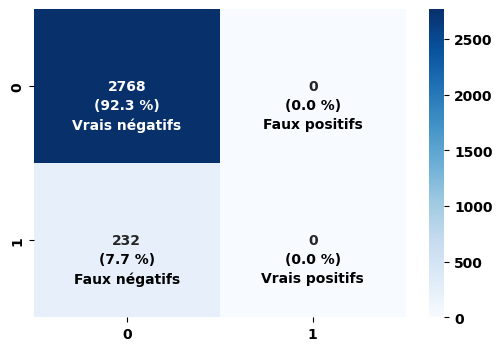

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


In [71]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                     "imputer" : [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean')],
                     "scaler" : [None, StandardScaler(), RobustScaler()],
                     "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()]
}

# On instancie le modèle
knn = DummyClassifier(random_state = 42)

# On ajoute en plus du nom du classifier
name = "DummyClassifier"

# On commence l'enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:
    
    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, knn, param_grid_search, xtrain, ytrain, xtest, ytest)
    
    # On catalogue le dataset utilisé, les paramètres grids et les métriques produites  
    log_mlflow(param_grid_search, mask, dataset_name, results, model)
    
# On ajoute à la liste de résultats des modèles
resultats_models.append(results)

### <a name = "T3C3">c. KNeighborsClassifier</a>

Nous testons 288 hyperparamètres
Fitting 5 folds for each of 288 candidates, totalling 1440 fits



1080 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 339, in _fit
    self._validate_steps()
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 230, in _validate_steps
    raise 




____________________________________________________________________________________________________
Meilleurs paramètres : {'imputer': SimpleImputer(strategy='median'), 'model__n_neighbors': 10, 'model__weights': 'uniform', 'sampler': None, 'scaler': None}
Temps de recherche des meilleurs paramètres : 21.1
Temps d'exécution : 0.9
____________________
Résultats sur échantillons d'entraînement :
Score performance : 84.49 %
Erreur : 7.76 %
ROC_AUC : 0.81
____________________
Résultats sur échantillons de test :
Score performance : 84.53 %
Erreur : 7.73 %
ROC_AUC : 0.53
Precision moyenne : 0.46 
Recall moyen : 0.50 
F1-Score moyen : 0.48 
Cross-validation score : 84.49 % avec un écart-type de 0.07 % 

____________________________________________________________________________________________________



              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2768
           1       0.00      0.00      0.00       232

    accuracy         

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


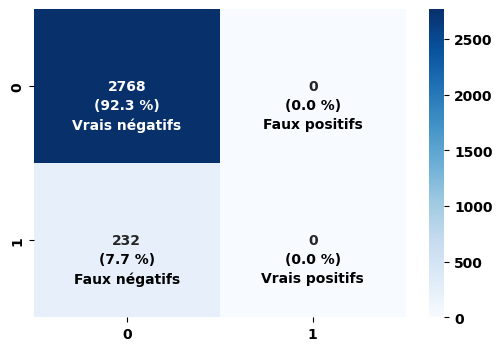

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/500 [00:00<?, ?it/s]

Utilisation de SHAP pour une explication indépendante des modèles
En quoi les variables contribue à un défaut de paiement :


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


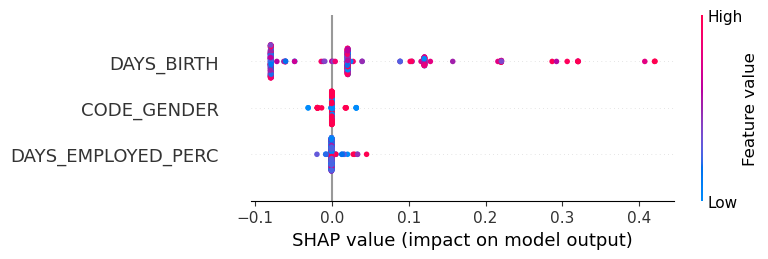

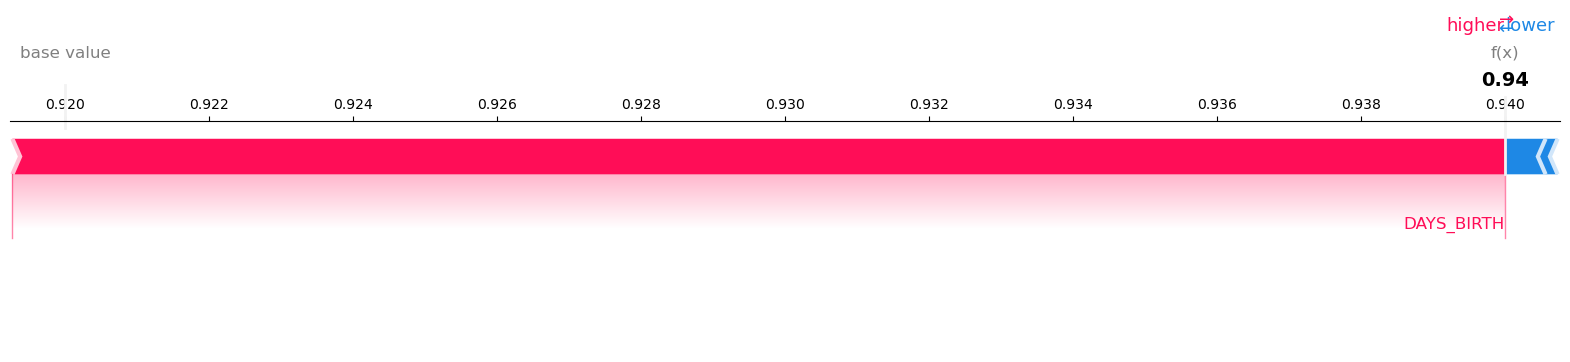

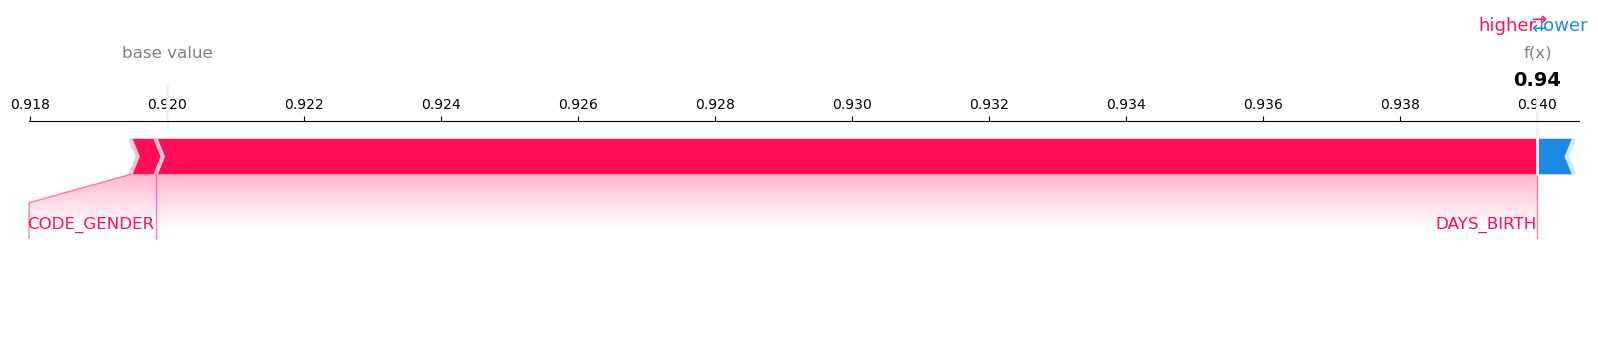

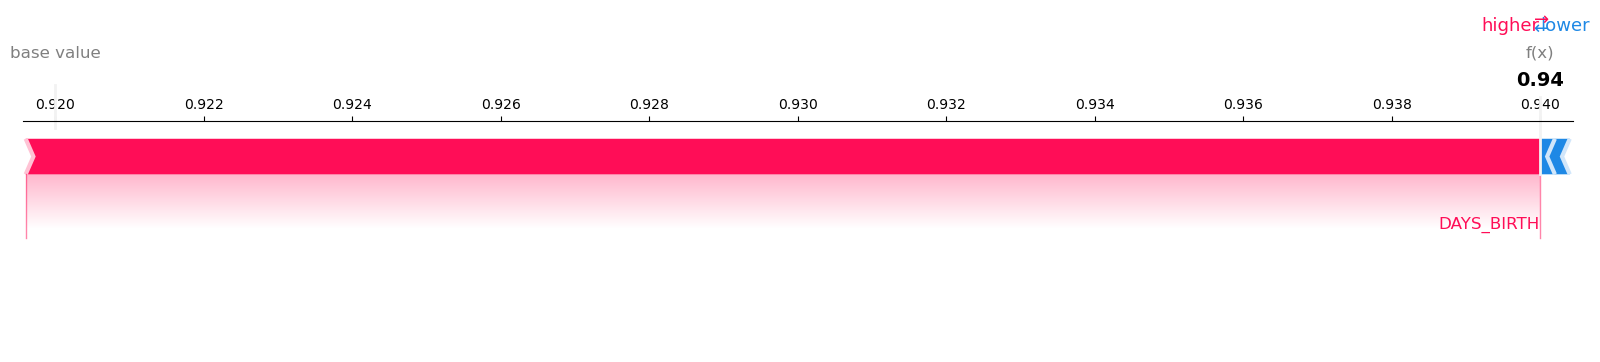

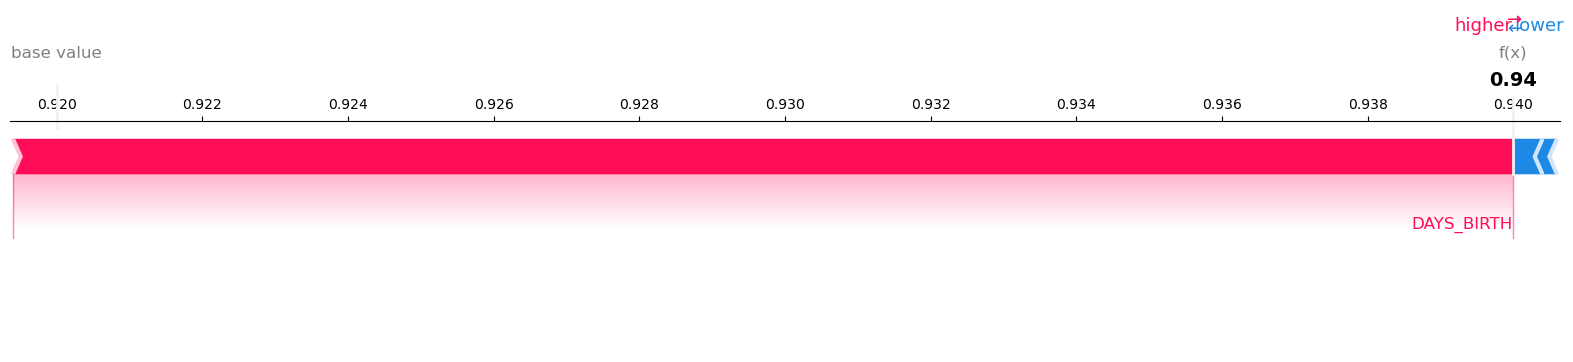

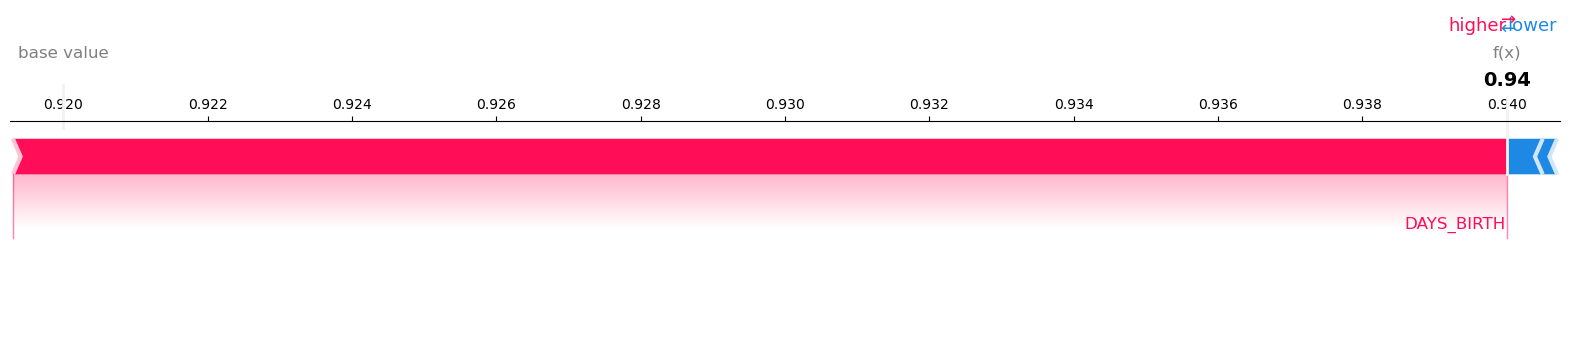

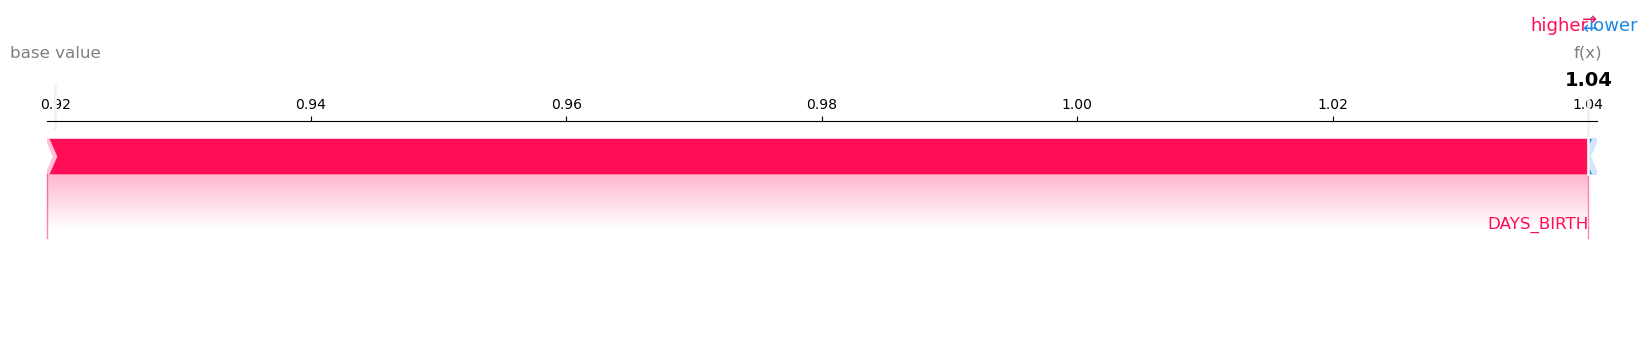

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


In [72]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                     "imputer" : [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean')],
                     "scaler" : [None, StandardScaler(), RobustScaler()],
                     "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()],
                    "model__n_neighbors" : [2, 5, 8, 10, 20, 50], 
                   "model__weights" : ["uniform", "distance"]}

# On instancie le modèle
knn = KNeighborsClassifier()

# On ajoute en plus du nom du classifier
name = "KNeighborsClassifier"

# On commence l'enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:
    
    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, knn, param_grid_search, xtrain, ytrain, xtest, ytest, "kernel")
    
    # On catalogue le dataset utilisé, les paramètres grids, les métriques produites et le modèle retenu  
    log_mlflow(param_grid_search, mask, dataset_name, results, model)

# On ajoute à la liste de résultats des modèles
resultats_models.append(results)

### <a name = "T3C4">d. RandomForestClassifier</a>

Nous testons 108 hyperparamètres
Fitting 5 folds for each of 108 candidates, totalling 540 fits



380 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 339, in _fit
    self._validate_steps()
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 230, in _validate_steps
    raise Ty




____________________________________________________________________________________________________
Meilleurs paramètres : {'scaler': RobustScaler(), 'sampler': None, 'model__n_estimators': 100, 'model__max_depth': 5, 'imputer': SimpleImputer()}
Temps de recherche des meilleurs paramètres : 113.1
Temps d'exécution : 1.1
____________________
Résultats sur échantillons d'entraînement :
Score performance : 84.49 %
Erreur : 7.76 %
ROC_AUC : 0.74
____________________
Résultats sur échantillons de test :
Score performance : 84.53 %
Erreur : 7.73 %
ROC_AUC : 0.65
Precision moyenne : 0.46 
Recall moyen : 0.50 
F1-Score moyen : 0.48 
Cross-validation score : 84.49 % avec un écart-type de 0.07 % 

____________________________________________________________________________________________________



              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2768
           1       0.00      0.00      0.00       232

    accuracy                   

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


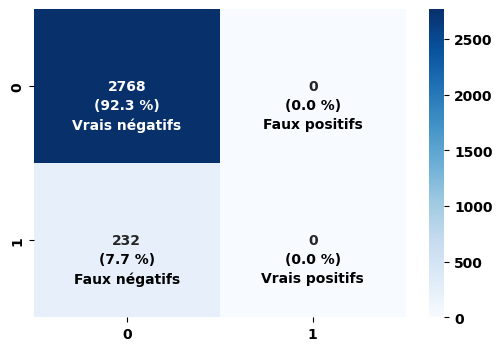

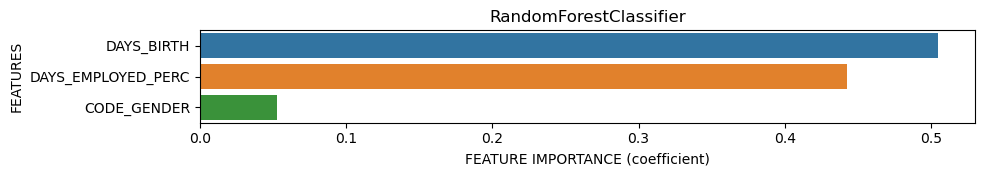

Utilisation de SHAP pour une explication indépendante des modèles
En quoi les variables contribue à un défaut de paiement :


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


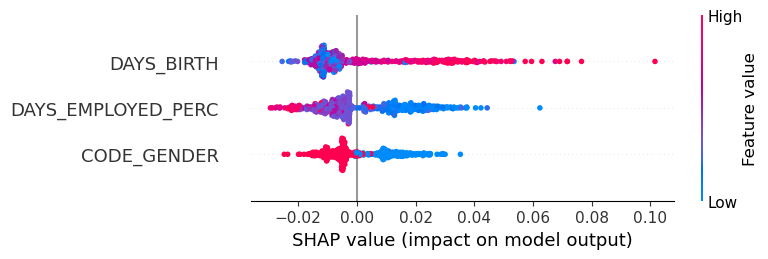

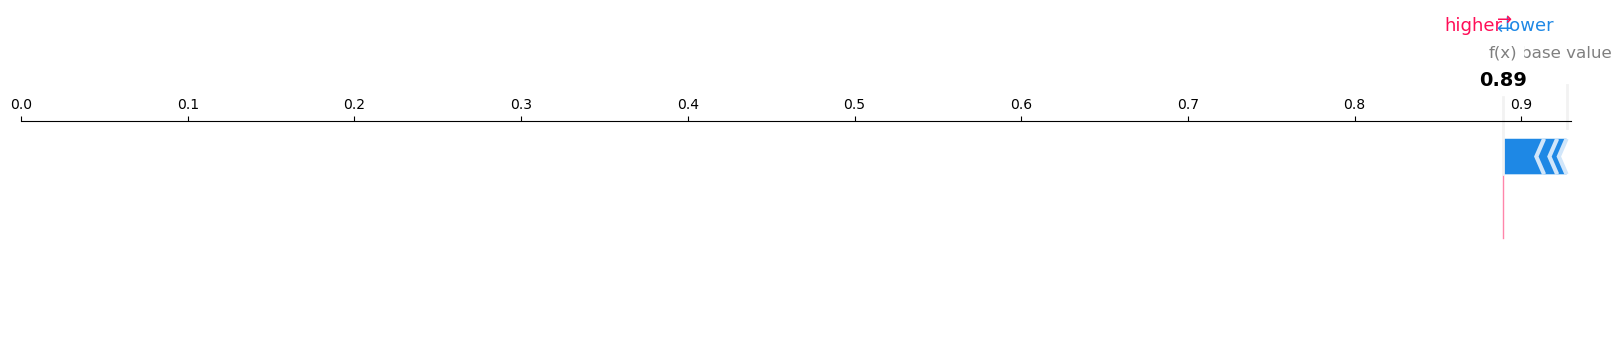

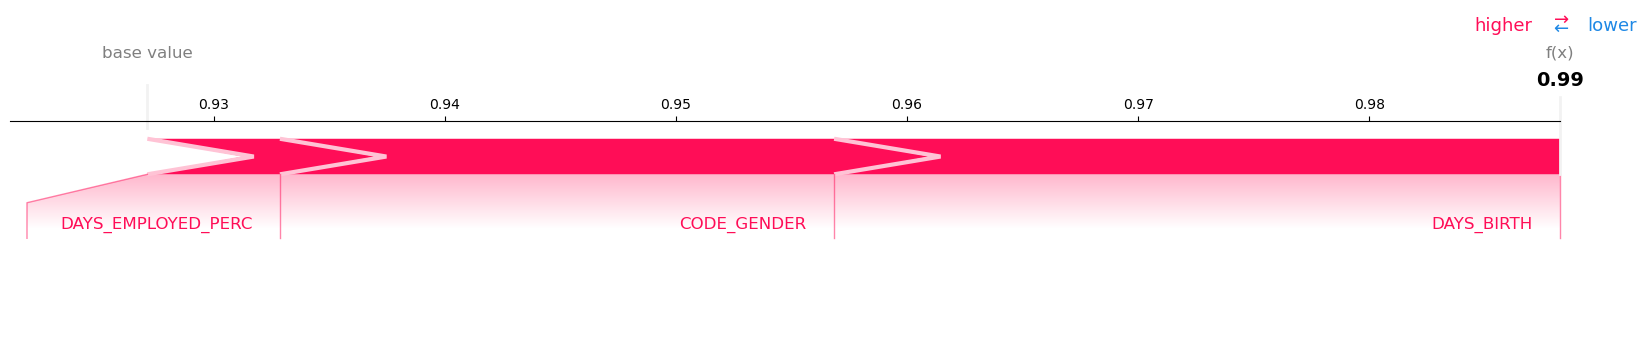

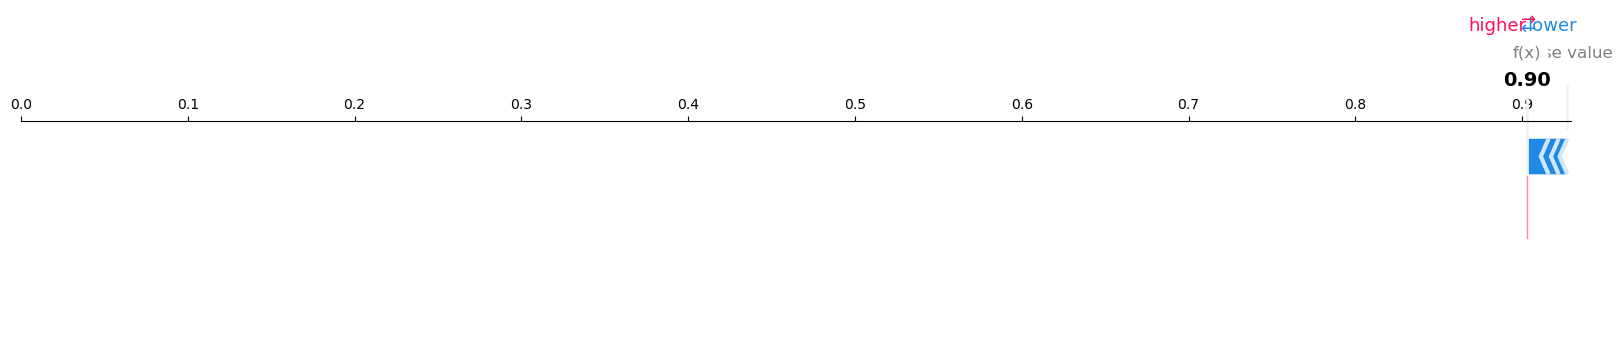

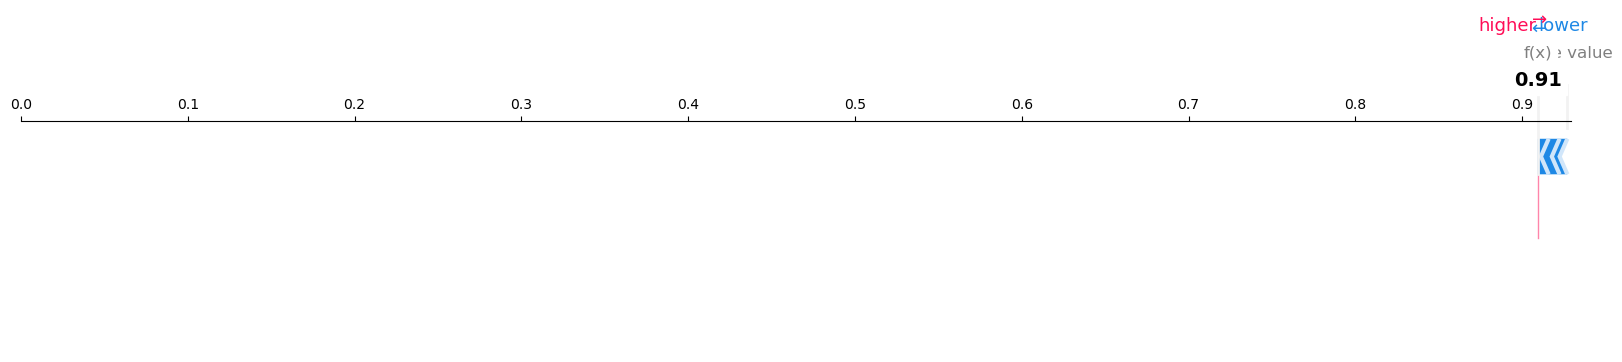

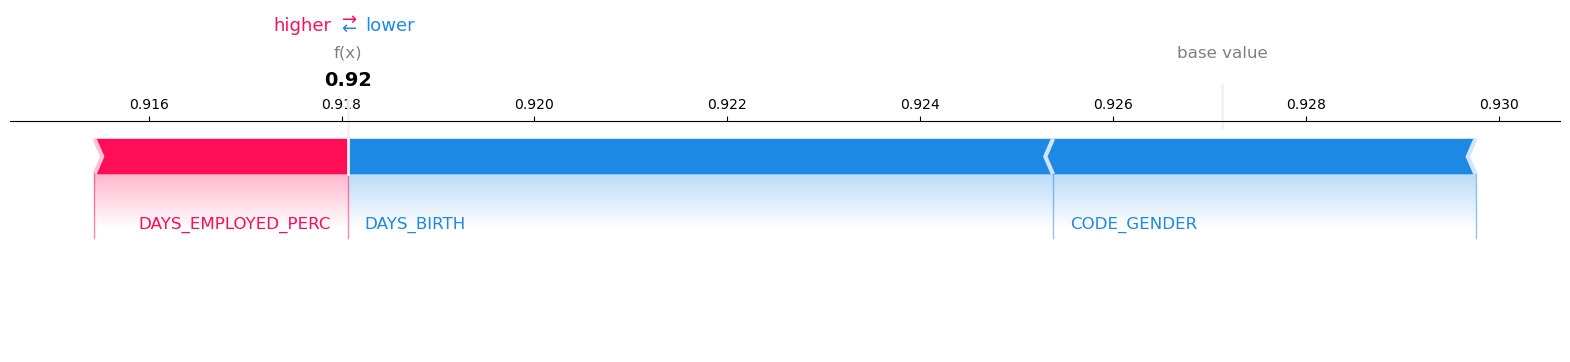

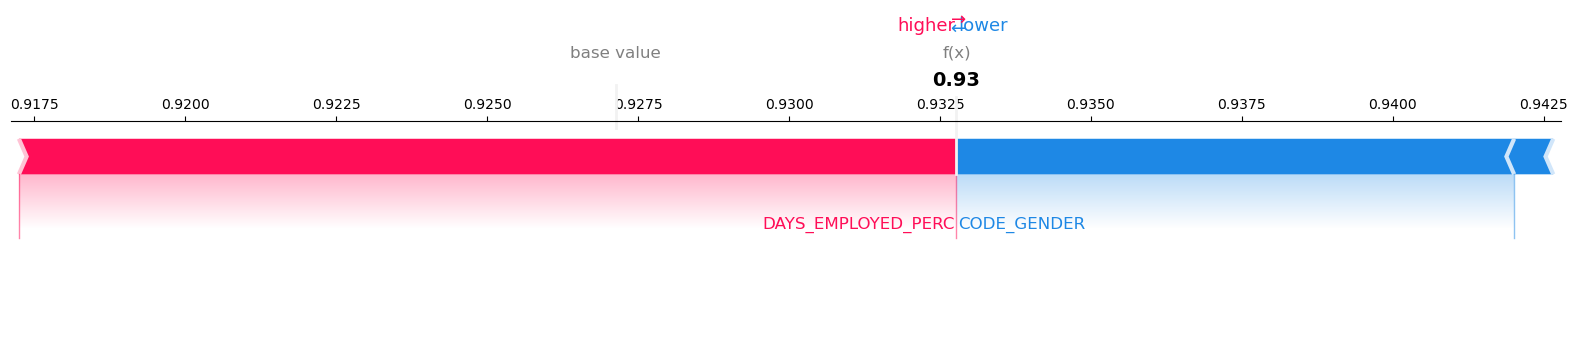

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


In [73]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                "imputer" : [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean')],
                "scaler" : [None, StandardScaler(), RobustScaler()],
                "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()],
                "model__n_estimators" : [100, 1000], 
                "model__max_depth" : [5, 7, 9]}

# On instancie le modèle
rfc = RandomForestClassifier(n_jobs = -1, random_state = 42)

# On ajoute en plus du nom du classifier
name = "RandomForestClassifier"

# On commence l'enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:
    
    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, rfc, param_grid_search, xtrain, ytrain, xtest, ytest, "DecisionTree")
    
    # On catalogue le dataset utilisé, les paramètres grids et les métriques produites    
    log_mlflow(param_grid_search, mask, dataset_name, results, model)

# On ajoute à la liste de résultats des modèles
resultats_models.append(results)

### <a name = "T3C5">e. LogisticRegression</a>

Nous testons 384 hyperparamètres
Fitting 5 folds for each of 384 candidates, totalling 1920 fits



1800 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1160, in fit
    self._validate_params()
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_cons




____________________________________________________________________________________________________
Meilleurs paramètres : {'imputer': SimpleImputer(strategy='median'), 'model__C': 0.1, 'model__class_weight': 'balanced', 'model__max_iter': 100, 'model__penalty': 'l2', 'sampler': None, 'scaler': None}
Temps de recherche des meilleurs paramètres : 7.8
Temps d'exécution : 0.1
____________________
Résultats sur échantillons d'entraînement :
Score performance : 84.49 %
Erreur : 7.76 %
ROC_AUC : 0.58
____________________
Résultats sur échantillons de test :
Score performance : 84.53 %
Erreur : 7.73 %
ROC_AUC : 0.65
Precision moyenne : 0.46 
Recall moyen : 0.50 
F1-Score moyen : 0.48 
Cross-validation score : 84.49 % avec un écart-type de 0.07 % 

____________________________________________________________________________________________________



              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2768
           1       0.00      0.0

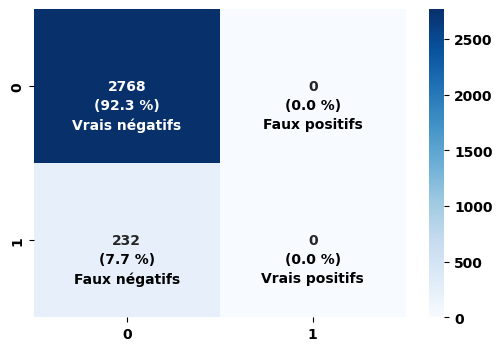

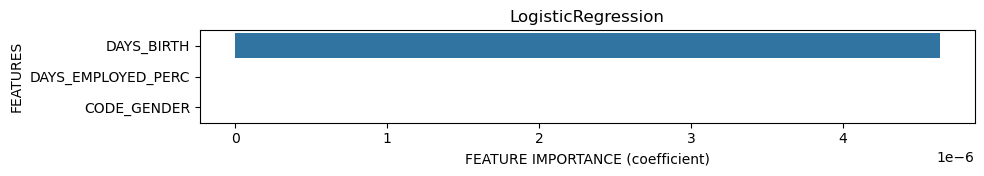

Utilisation de SHAP pour une explication indépendante des modèles
En quoi les variables contribue à un défaut de paiement :


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


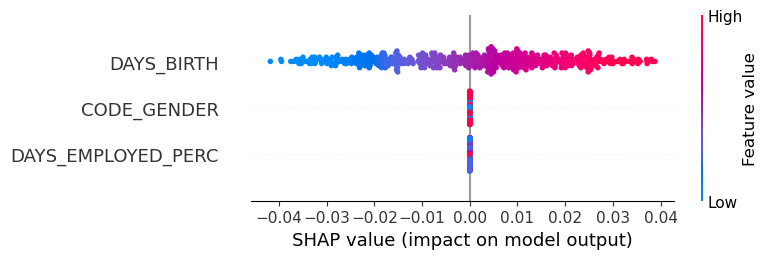

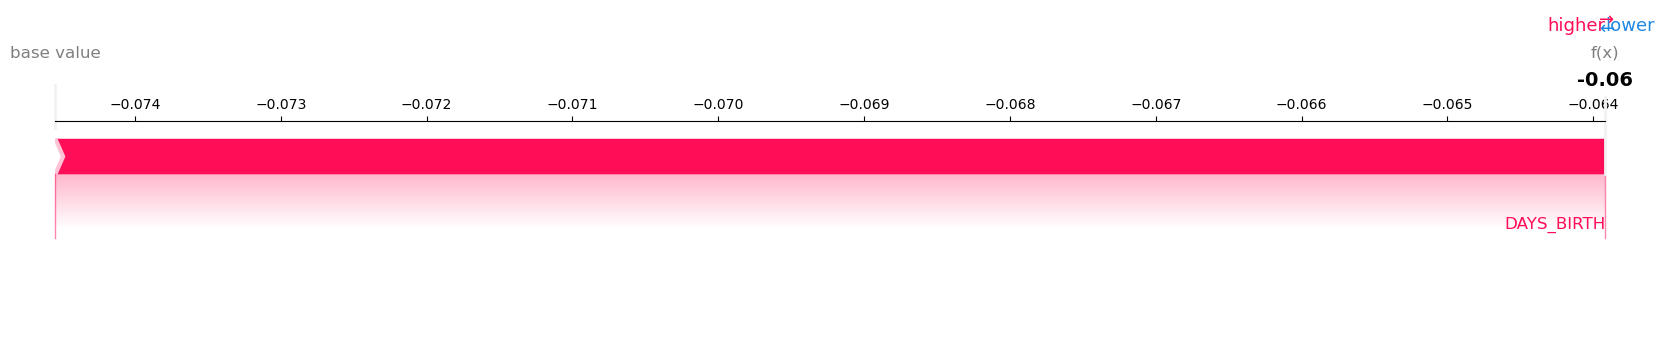

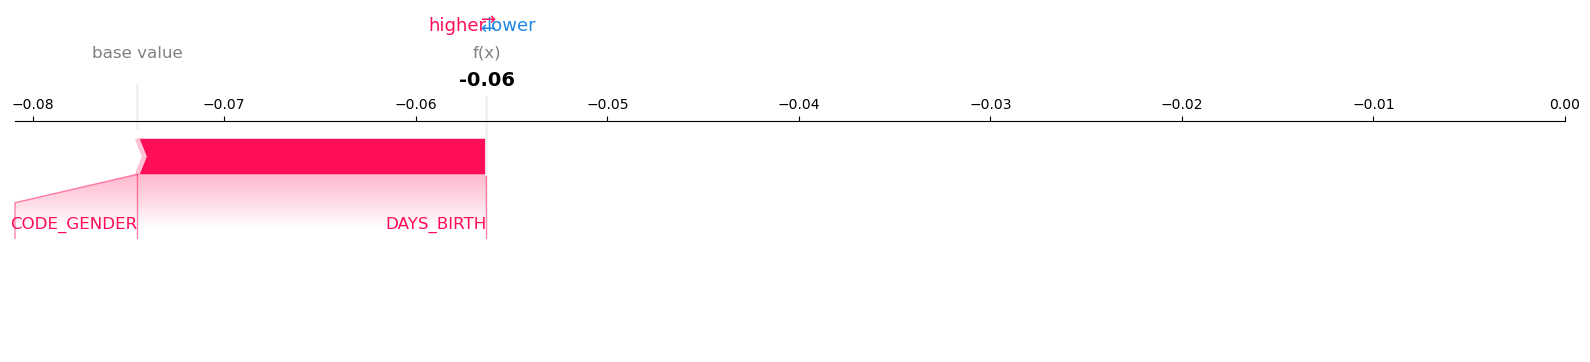

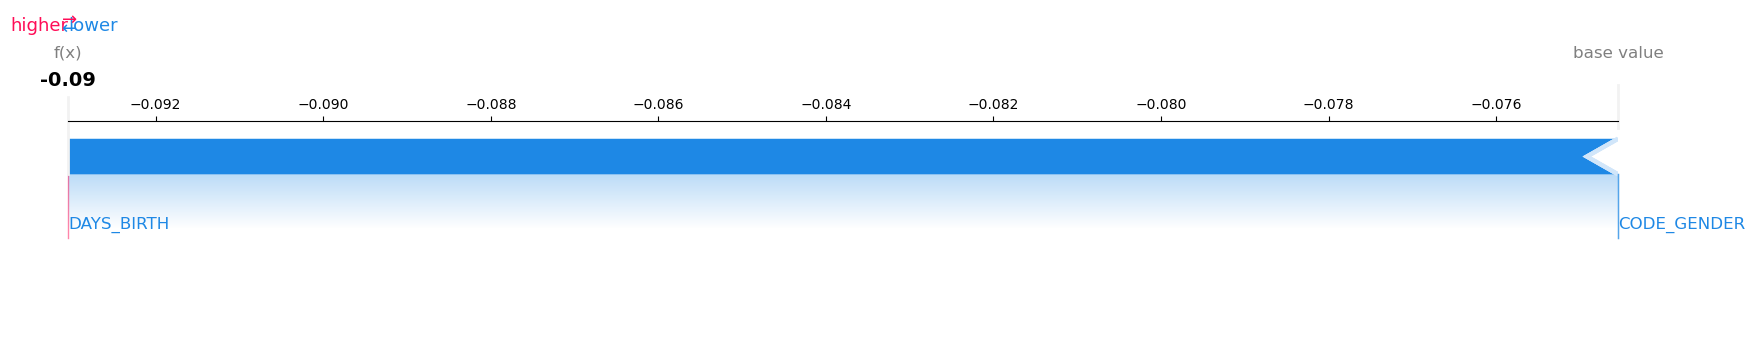

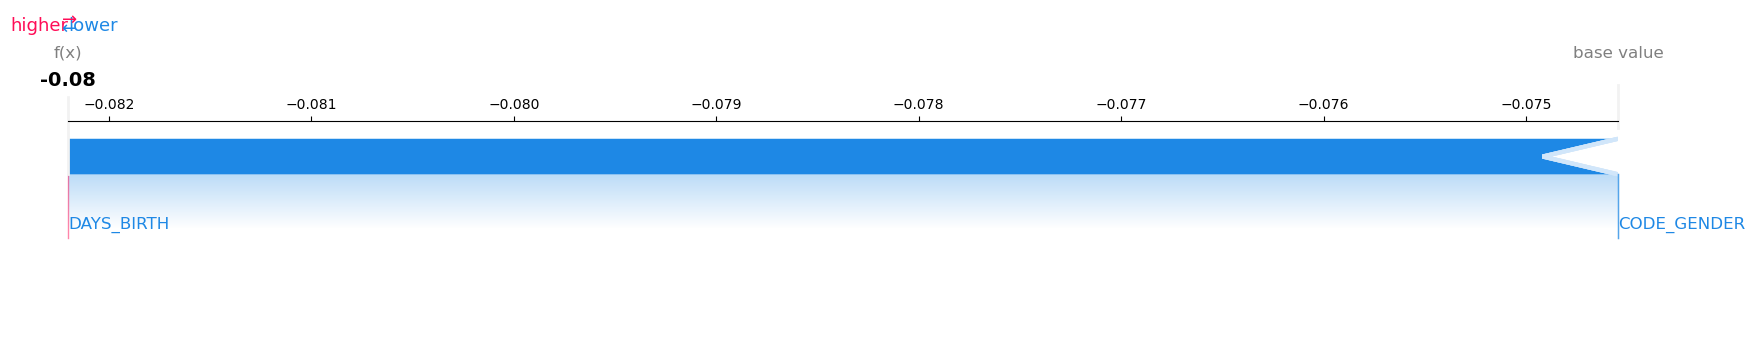

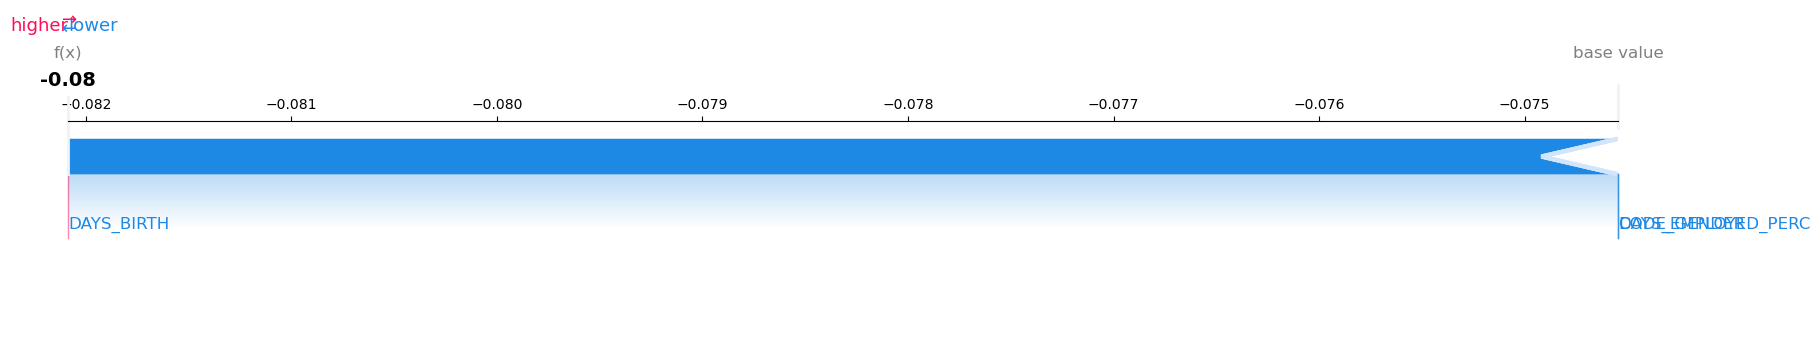

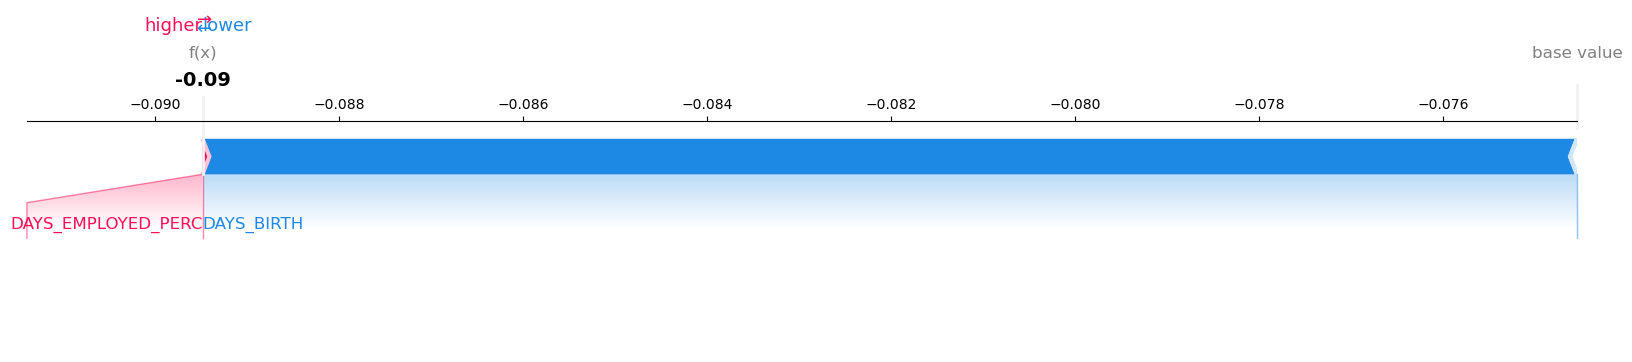

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


In [74]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                    "imputer" : [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean')],
                    "scaler" : [None, StandardScaler(), RobustScaler()],
                    "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()],
                    "model__penalty" : ["l2", "elasticnet"],
                    "model__class_weight" : ["None", "balanced"], 
                    "model__C" : [0.1, 1],
                    "model__max_iter" : [100, 1000]}

# On instancie le modèle
modele_LR = LogisticRegression(n_jobs = -1, random_state = 42)

# On ajoute en plus du nom du classifier
name = "LogisticRegression"

# On commence l'enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:
    
    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, modele_LR, param_grid_search, xtrain, ytrain, xtest, ytest, "Regression")
    
    # On catalogue le dataset utilisé, les paramètres grids et les métriques produites    
    log_mlflow(param_grid_search, mask, dataset_name, results, model)

# On ajoute à la liste de résultats des modèles
resultats_models.append(results)

### <a name = "T3C6">f. GradientBoostingClassifier</a>

Nous testons 288 hyperparamètres
Fitting 5 folds for each of 288 candidates, totalling 1440 fits



1075 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 339, in _fit
    self._validate_steps()
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 230, in _validate_steps
    raise 




____________________________________________________________________________________________________
Meilleurs paramètres : {'scaler': RobustScaler(), 'sampler': None, 'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'imputer': SimpleImputer(strategy='median')}
Temps de recherche des meilleurs paramètres : 498.8
Temps d'exécution : 3.4
____________________
Résultats sur échantillons d'entraînement :
Score performance : 84.89 %
Erreur : 7.56 %
ROC_AUC : 0.74
____________________
Résultats sur échantillons de test :
Score performance : 84.17 %
Erreur : 7.77 %
ROC_AUC : 0.63
Precision moyenne : 0.46 
Recall moyen : 0.50 
F1-Score moyen : 0.48 
Cross-validation score : 83.89 % avec un écart-type de 0.86 % 

____________________________________________________________________________________________________



              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2768
         

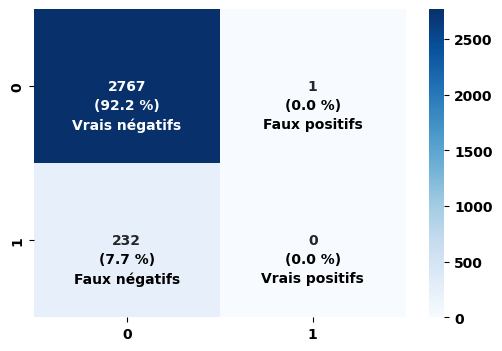

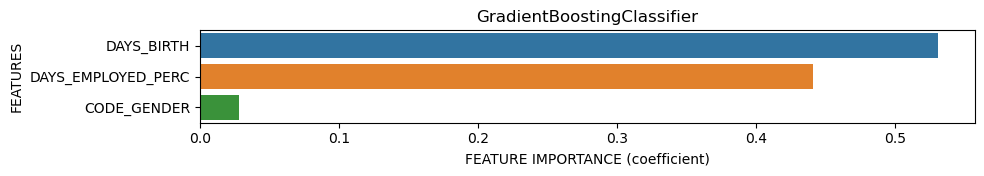

Utilisation de SHAP pour une explication indépendante des modèles
En quoi les variables contribue à un défaut de paiement :


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


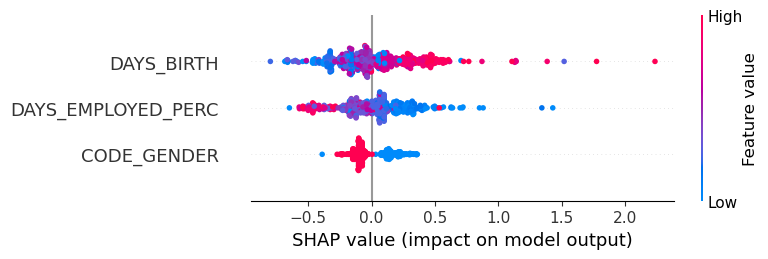

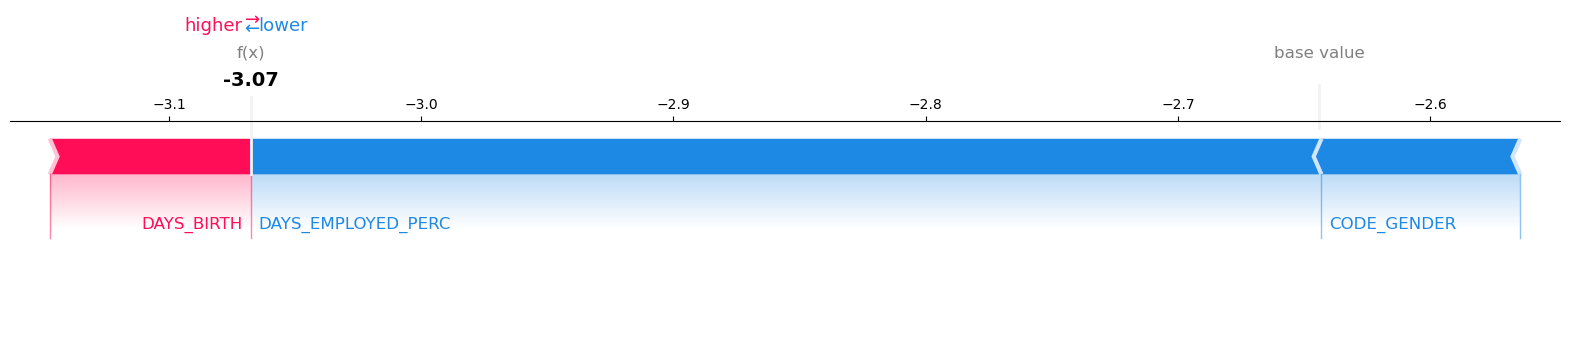

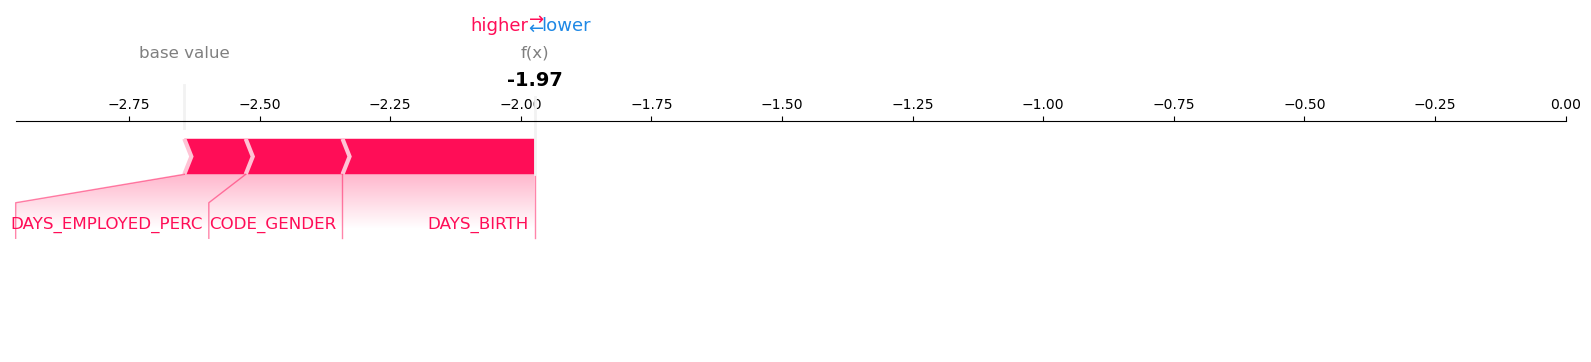

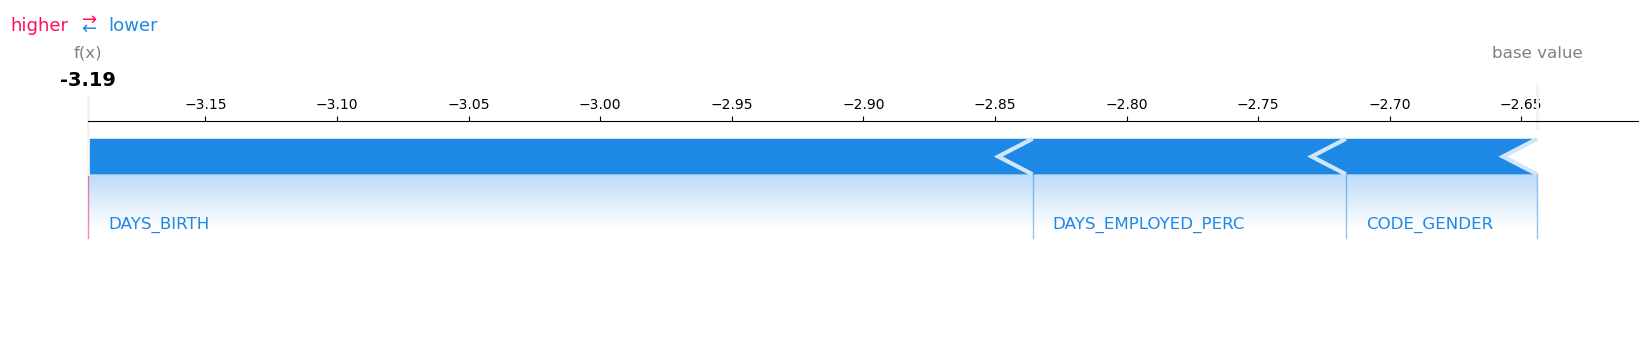

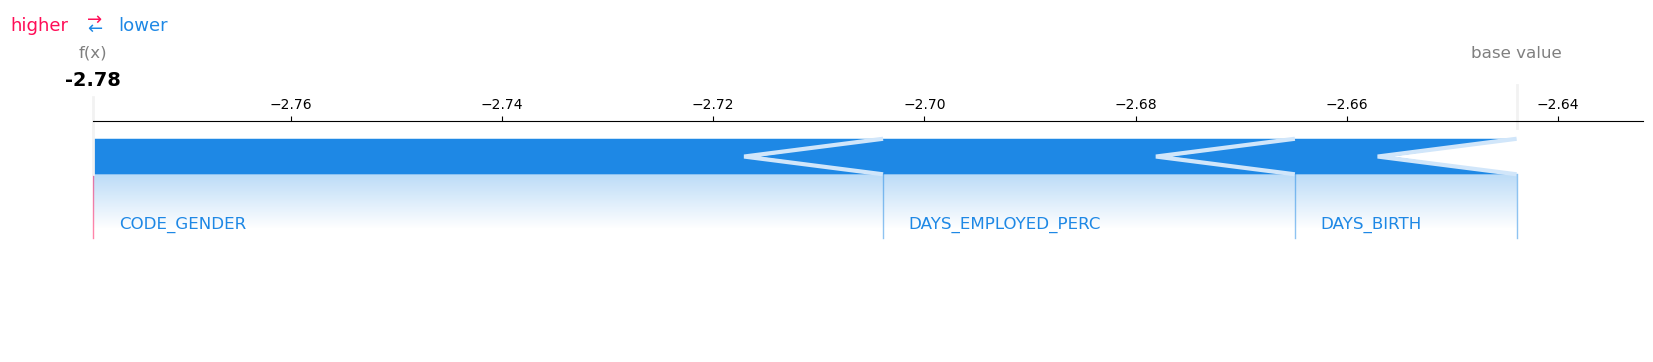

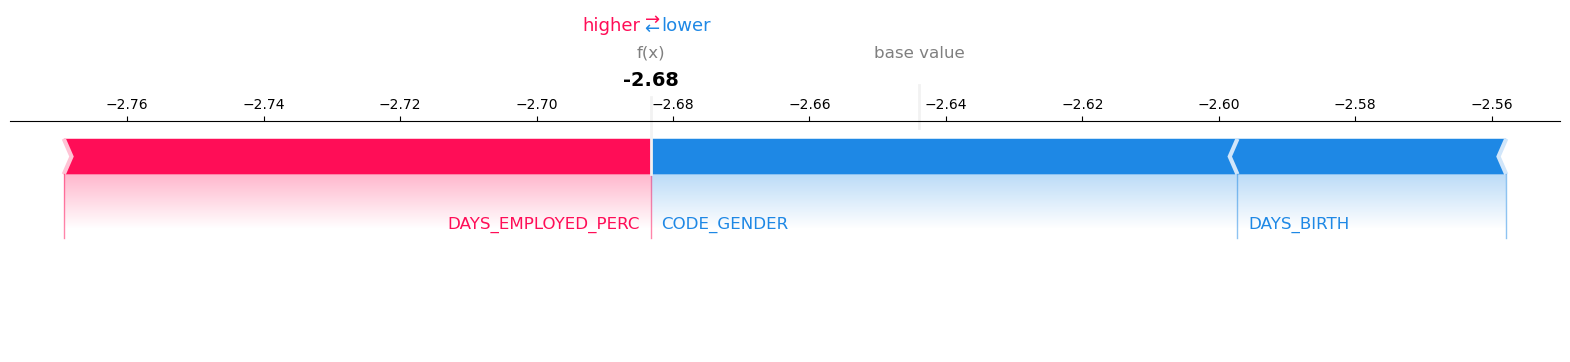

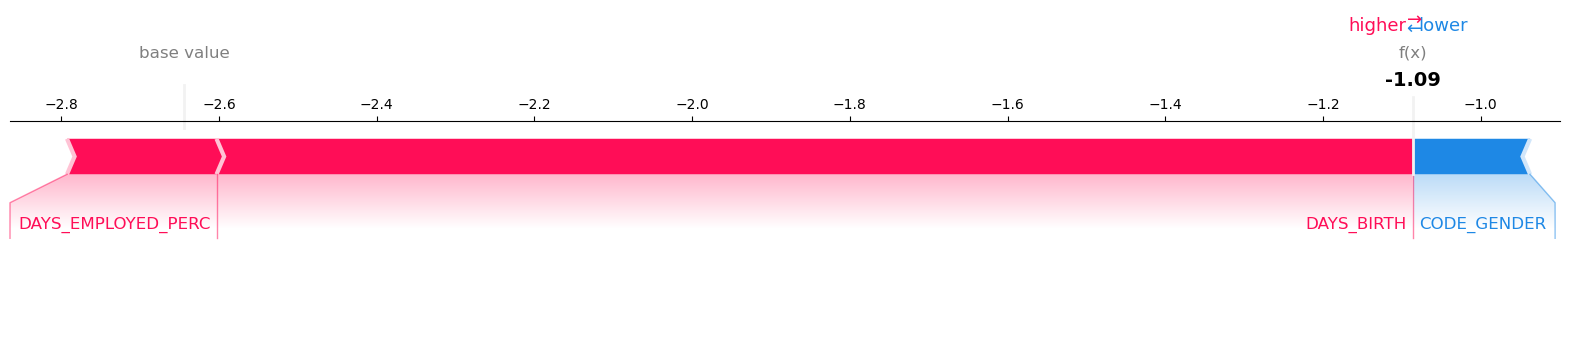

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


In [75]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                    "imputer" : [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean')],
                    "scaler" : [None, StandardScaler(), RobustScaler()],
                    "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()],
                    'model__n_estimators': [100, 200],#[50, 100, 200, 300, 500],
                    'model__max_depth': [3, 7],#[3, 5, 7, 10, 14, None], 
                    'model__min_samples_split': [2, 5],#[2, 5, 10],
                    'model__learning_rate' : [0.1, 1]}

# On instancie le modèle
modele_GB = GradientBoostingClassifier(random_state = 42)

# On ajoute en plus du nom du classifier
name = "GradientBoostingClassifier"

# On commence l'enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:

    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, modele_GB, param_grid_search, xtrain, ytrain, xtest, ytest, "DecisionTree")
    
    # On catalogue le dataset utilisé, les paramètres grids et les métriques produites    
    log_mlflow(param_grid_search, mask, dataset_name, results, model)

# On ajoute à la liste de résultats des modèles
resultats_models.append(results)

### <a name = "T3C7">g. XGBClassifier</a>

Nous testons 144 hyperparamètres
Fitting 5 folds for each of 144 candidates, totalling 720 fits



515 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
165 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 339, in _fit
    self._validate_steps()
  File "C:\Users\33664\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 230, in _validate_steps
    raise Ty




____________________________________________________________________________________________________
Meilleurs paramètres : {'scaler': StandardScaler(), 'sampler': None, 'model__n_estimators': 200, 'model__max_depth': 3, 'model__eta': 0.01, 'imputer': SimpleImputer()}
Temps de recherche des meilleurs paramètres : 54.4
Temps d'exécution : 1.4
____________________
Résultats sur échantillons d'entraînement :
Score performance : 84.49 %
Erreur : 7.76 %
ROC_AUC : 0.65
____________________
Résultats sur échantillons de test :
Score performance : 84.53 %
Erreur : 7.73 %
ROC_AUC : 0.65
Precision moyenne : 0.46 
Recall moyen : 0.50 
F1-Score moyen : 0.48 
Cross-validation score : 84.49 % avec un écart-type de 0.07 % 

____________________________________________________________________________________________________



              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2768
           1       0.00      0.00      0.00       232

    accura

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


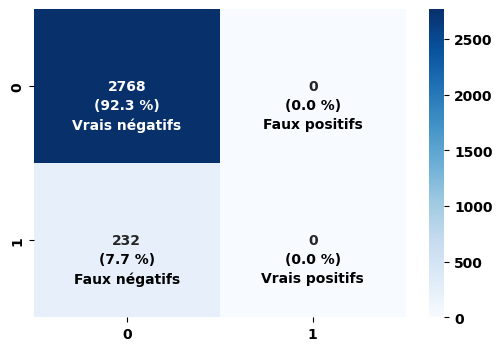

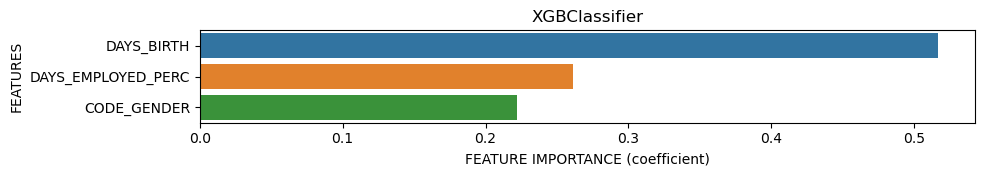

Utilisation de SHAP pour une explication indépendante des modèles
En quoi les variables contribue à un défaut de paiement :


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


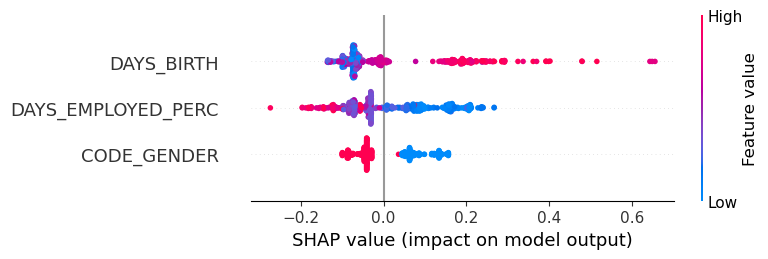

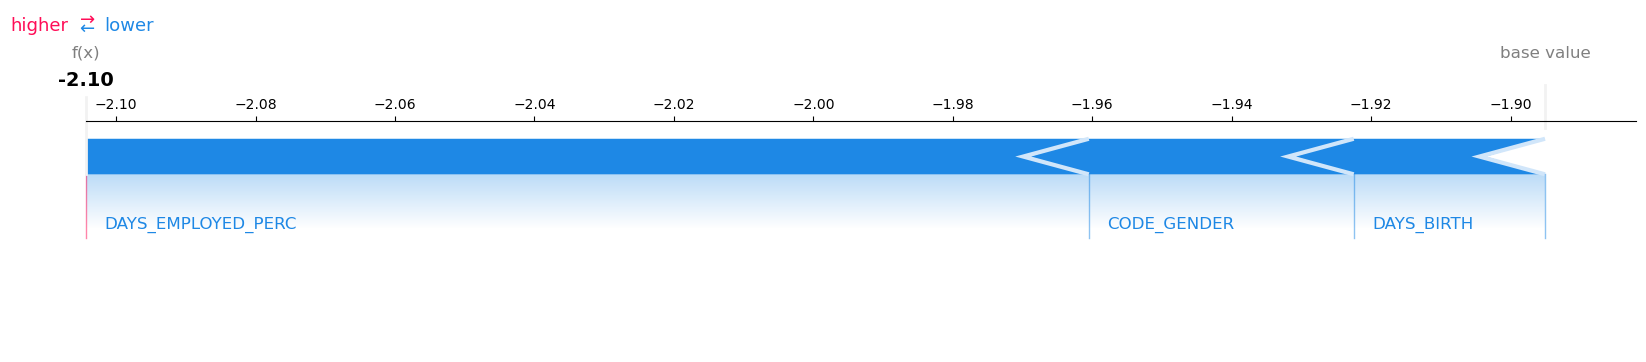

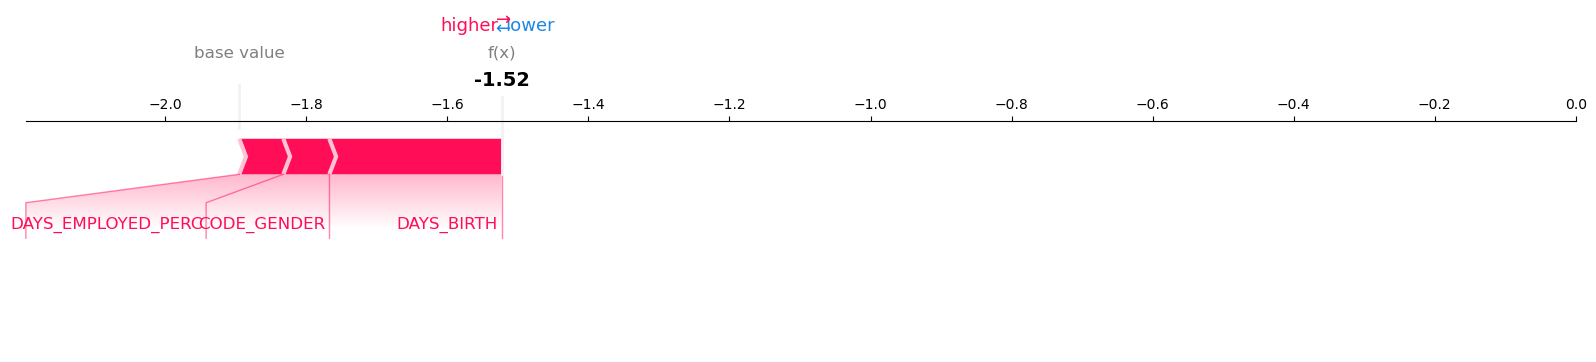

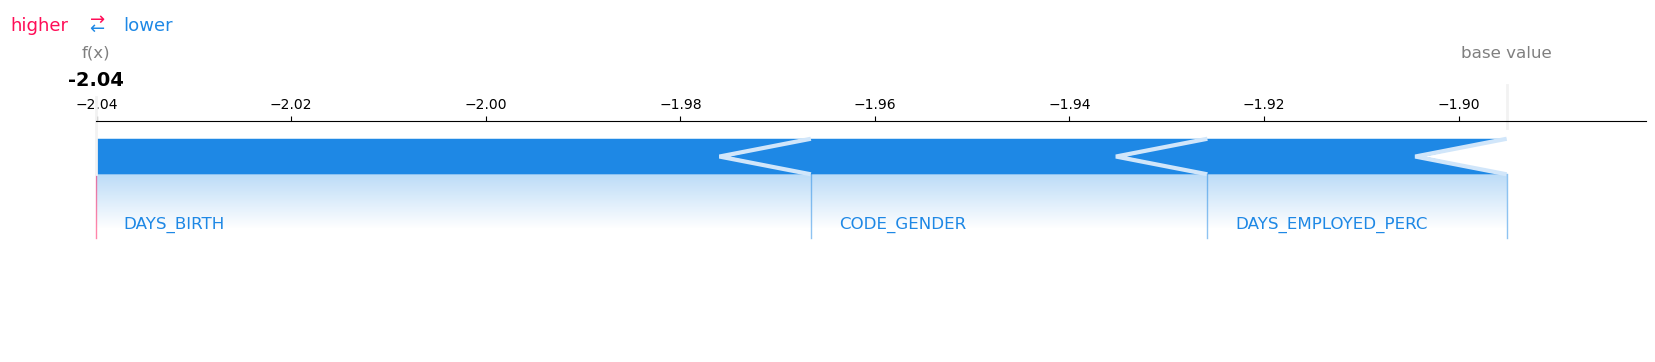

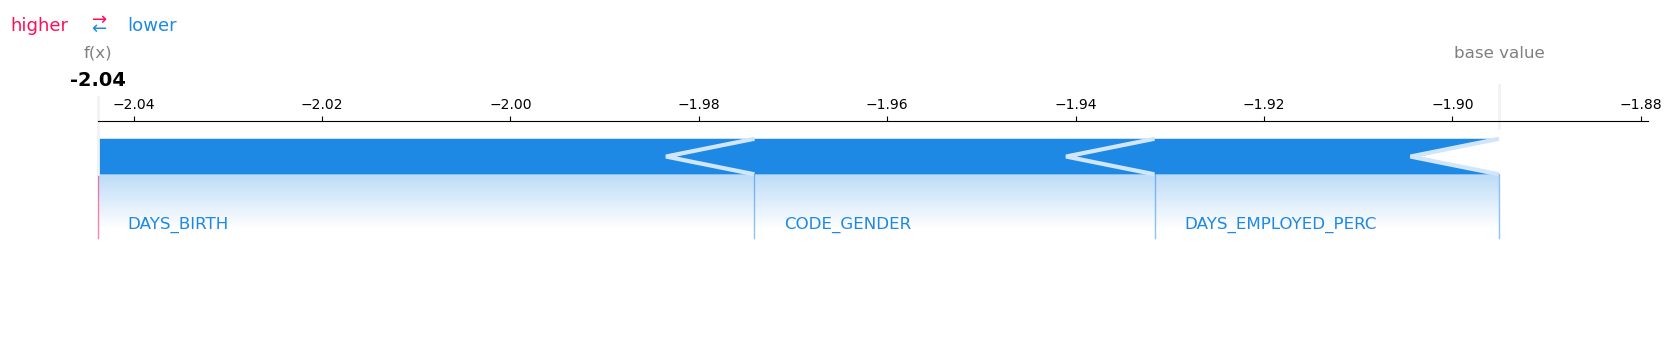

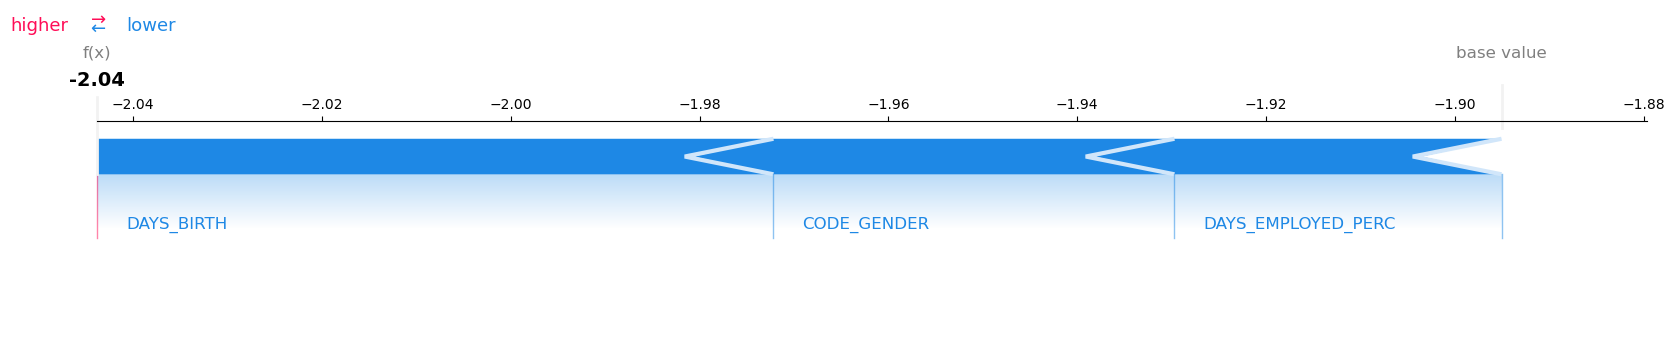

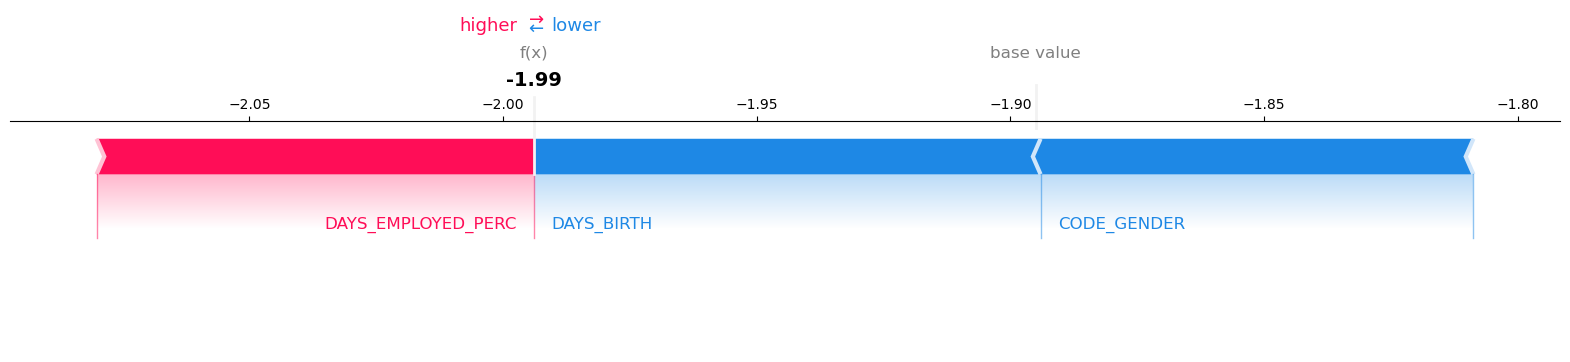

The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.


In [76]:
# On recherche les meilleurs hyperparamètres
param_grid_search = {
                   "imputer" : [SimpleImputer(strategy='median'), SimpleImputer(strategy='mean')],
                    "scaler" : [None, StandardScaler(), RobustScaler()],
                     "sampler" : [None, NearMiss(), SMOTE(), SMOTEENN()],
                    'model__n_estimators': [100, 200],#[10, 100, 300, 500, 1000],
                    'model__max_depth': [3, 7],# [3, 5, 7, 10], 
                    'model__eta' : [0.01, 0.1]}#[0.01, 0.1, 0.3]

# On instancie le modèle
modele_XGB = XGBClassifier(random_state = 42)

# On ajoute en plus du nom du classifier
name = "XGBClassifier"

# On commence l'enregistrement mlflow 
with mlflow.start_run(run_name=name) as run:

    # On récupère les résultats après application de la fonction search_model_params
    results, model = search_model_params(name, modele_XGB, param_grid_search, xtrain, ytrain, xtest, ytest, "DecisionTree")
    
    # On catalogue le dataset utilisé, les paramètres grids et les métriques produites    
    log_mlflow(param_grid_search, mask, dataset_name, results, model)

# On ajoute à la liste de résultats des modèles
resultats_models.append(results)

In [77]:
pd.DataFrame(resultats_models, 
             columns = [
                 "model",  
                 "score_performance_train", 
                 "score_performance_test",
                 "roc_auc_score_train", 
                 "roc_auc_score_test", 
                 "errors_score_train", 
                 "errors_score_test", 
                 "precision_mean",
                 "recall_mean",
                 "f1_mean",
                 "training_time", 
                 "applying_time"
             ])

,model,score_performance_train,score_performance_test,roc_auc_score_train,roc_auc_score_test,errors_score_train,errors_score_test,precision_mean,recall_mean,f1_mean,training_time,applying_time
0,DummyClassifier,84.485714,84.533333,0.50,0.50,7.76,7.73,0.46,0.5,0.48,0.6,0.1
1,KNeighborsClassifier,84.485714,84.533333,0.81,0.53,7.76,7.73,0.46,0.5,0.48,21.1,0.9
2,RandomForestClassifier,84.485714,84.533333,0.74,0.65,7.76,7.73,0.46,0.5,0.48,113.1,1.1
3,LogisticRegression,84.485714,84.533333,0.58,0.65,7.76,7.73,0.46,0.5,0.48,7.8,0.1
4,GradientBoostingClassifier,84.885714,84.166667,0.74,0.63,7.56,7.77,0.46,0.5,0.48,498.8,3.4
5,XGBClassifier,84.485714,84.533333,0.65,0.65,7.76,7.73,0.46,0.5,0.48,54.4,1.4


In [ ]:
#Partie test/debug

In [ ]:
param_grid_search = {
    "scaler" : [None, StandardScaler(), RobustScaler()],
                    }

# On instancie le modèle
modele_XGB = XGBClassifier(random_state = 42)



In [ ]:
pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', None),
        ('model', modele_XGB)
    ])

    # On utilise notre scorer, on veut maximiser le score
my_scorer = make_scorer(my_custom_score_func, greater_is_better=True)
    
    # On veut suivre plusieurs scores
scorers = {
    "custom_score" : my_scorer,
    "roc_auc" : "roc_auc"
    }
grid = GridSearchCV(pipe, param_grid_search, cv = 5, scoring = scorers, refit = "custom_score", verbose = 2)

# On fit sur les données d'entrainement
grid.fit(xtrain, ytrain)

# On récupère les meilleurs paramètres 
best_param_pipe = grid.best_estimator_

# On fit sur les données
best_param_pipe.fit(xtrain, ytrain)

In [ ]:
## DEBUG ##
## TEST focntionnalitées ##

# On recherche les meilleurs hyperparamètres
param_grid_search = {
                "imputer" : [SimpleImputer(strategy='median')],
                "scaler" : [None, StandardScaler(), RobustScaler()]}

# On instancie le modèle
rfc = LogisticRegression()
#rfc = XGBClassifier()

# On ajoute en plus du nom du classifier
name = "LogisticRegression"

# On récupère les résultats après application de la fonction search_model_params
results = search_model_params(name, rfc, param_grid_search, xtrain, ytrain, xtest, ytest, "Reggresion")

In [ ]:
results

In [ ]:
## DEBUG ##
## TEST focntionnalitées ##

# On recherche les meilleurs hyperparamètres
param_grid_search = {
                "imputer" : [SimpleImputer(strategy='median')],
                "scaler" : [None, StandardScaler(), RobustScaler()]}

# On instancie le modèle
rfc = RandomForestClassifier()
rfc = XGBClassifier()
for rfc, aaa in zip([RandomForestClassifier(), XGBClassifier(), KNeighborsClassifier()], ["DecisionTree", "DecisionTree", "kernel"]):
    # On ajoute en plus du nom du classifier
    name = "RandomForestClassifier"

    # On récupère les résultats après application de la fonction search_model_params
    results = search_model_params(name, rfc, param_grid_search, xtrain, ytrain, xtest, ytest, aaa)